<a id='step0'></a>
# Learning stock price behavior from earnings call transcripts

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model


<a id='step0'></a>
[Back to top](#step0)

## Overview 


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')
import seaborn as sns
sns.set()
import matplotlib.cm as cm

# Enable logging
import logging
import sys
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

<a id='step1'></a>
## Download the data
[Back to top](#step0)

* **[Step 1](#step1): Download the data**
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model

### Get list of S&P 500 companies

The following file contains information about S&P 500 companies downloaded from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). For this project, we'll only use the list of ticker symbols, but features such as `GICS_sector` and `GICS_sub_industry` might prove useful. 

In [85]:
column_names = ['ticker', 'security', 'filings', 'GICS_sector', 'GICS_sub_industry', 'HQ_address', 'date_added', 'CIK']
sp500companies = pd.read_csv('data/S&P500.csv', header = 0, names = column_names).drop(['filings'], axis=1)
sp500companies = sp500companies.set_index(['ticker'])
sp500companies.head(10)

,security,GICS_sector,GICS_sub_industry,HQ_address,date_added,CIK
ticker,,,,,,
MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/64,1800
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152
ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/11,1467373
ATVI,Activision Blizzard,Information Technology,Home Entertainment Software,"Santa Monica, California",8/31/15,718877
AYI,Acuity Brands Inc,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",5/3/16,1144215
ADBE,Adobe Systems Inc,Information Technology,Application Software,"San Jose, California",5/5/97,796343
AMD,Advanced Micro Devices Inc,Information Technology,Semiconductors,"Sunnyvale, California",3/20/17,2488
AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/15,1158449


### Download the price data

Run the cell below to download S&P 500 company prices between the two specified dates.

In [805]:
import pandas_datareader as pdr

start = pd.to_datetime('2009-01-01')
end = pd.to_datetime('2017-01-01')
source = 'google'

for company in sp500companies.index:
    try:
        price_data = pdr.DataReader(company, source, start, end)
        price_data['Close'].to_csv('data/company_prices/%s_adj_close.csv' % company)
    except:
        logging.error("Oops! %s occured for %s. \nMoving on to next entry." % (sys.exc_info()[0], company))

### Download the transcripts

Transcripts are scraped from [Seeking Alpha](https://seekingalpha.com/) using the Python library [Scrapy](https://docs.scrapy.org/en/latest/).

To fetch a company transcript, complete the following steps. 

```
cd data/
scrapy crawl transcripts -a symbol=$SYM
```

This will download all of the posted earnings call transcripts for company `SYM` and store it as a JSON lines file in `data/company_transcripts/SYM.json`.

<a id='step2'></a>
## Load the data

* [Step 1](#step1): Download the data
* **[Step 2](#step2): Load the data**
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model

[Back to top](#step0)

### Load transcript data

In [2]:
# Read in a collection of company transcripts
def load_company_transcripts(company):
    '''
    Reads a company's transcripts into a Pandas DataFrame. 
    
    Args:
        company: The ticker symbol for the desired company. 
    '''
    logging.debug('Reading company transcripts for {}'.format(company))
    
    # Read file
    text_data = pd.read_json('data/company_transcripts/{}.json'.format(company), lines=True)
    
    # Drop events that don't have an associated date
    text_data = text_data.dropna(axis = 0, subset= ['date'])
    
    # Reindex according to the date
    text_data = text_data.set_index('date').sort_index()
    
    # Check for possible duplicate entries from scraping
    if sum(text_data.duplicated(['title'])) > 0:
        logging.warning('{} duplicates removed from file'.format(sum(text_data.duplicated(['title']))))
        text_data = text_data.drop_duplicates(['title'])
               
    # Concatenate body into single body of text
    text_data['body'] = text_data['body'].apply(lambda x: ' '.join(x))
    
    # Add a column to each transcript for word count, plot histogram
    text_data['count'] = text_data['body'].apply(lambda x: len(x.split()))
    
    # Check for empty transcripts
    if len(text_data[text_data['count'] == 0]) > 0:
        logging.warning('{} empty transcripts removed from file'.format(len(text_data[text_data['count'] == 0])))
    text_data = text_data[text_data['count'] != 0]
    
    return text_data

### Load price data

In [3]:
def load_company_price_history(companies, normalize = False, fillna = True, dropna=True):
    ''' 
    Builds a DataFrame where each column contains one company's adjusted closing price history.
    
    Args:
        companies: A list of company ticker symbols to load.
        normalize: Boolean flag to calculate the log-returns from the raw price data. 
        fillna: Boolean flag to fill null values. Limited fill up to 5 days forward and 1 day backward,
        for companies with long periods of null values, this prevents from creating a stagnant time series.
        Instead, those companies should be dropped using `dropna=true`.
        dropna: Boolean flag to drop companies that don't have a full price history. 
         
    '''
    prices = []
    for company in companies:
        logging.debug('Reading company prices for {}'.format(company))
        price_history = pd.read_csv('data/company_prices/{}_adj_close.csv'.format(company), 
                                    names=[company], index_col=0)
        prices.append(price_history)
        
    df = pd.concat(prices, axis=1)
    df.index = pd.to_datetime(df.index)
    df = df.asfreq('B', method='ffill')
   
    if normalize:
        df = np.log(df).diff() # Calculate the log-return, first value becomes null
        df.iloc[0] = df.iloc[1] # Forward fill the null value
        
    if fillna:
        df = df.fillna(method = 'ffill', limit=5) # First pass fill NAs as previous day price
        df = df.fillna(method = 'bfill', limit=1) # For NAs with no prev value (ie. first day), fill NA as next day price
    
    if dropna:
        # Validate quality of data (null values, etc)
        # Drop any companies that don't have a full 8-year history
        df = df.dropna(axis=1, how='any')
        assert df.isnull().values.any() == 0
        logging.debug('Null values found after cleaning: {}'.format(df.isnull().values.any()))
        
    
    return df

### Read file directory and load all available data

In [4]:
# Go to data folder and get list of all companies that have data
import glob
import re

# All files for price history
price_files = glob.glob('data/company_prices/*_adj_close.csv')
company_prices = [re.search(r'(?<=data\/company_prices\/)(.*)(?=_adj_close.csv)', f).group(0) 
                  for f in price_files]
logging.info('{} company price histories available.'.format(len(company_prices)))

# All files for transcripts
transcript_files = glob.glob('data/company_transcripts/*.json')
company_transcripts = [re.search(r'(?<=data\/company_transcripts\/)(.*)(?=.json)', f).group(0) 
                       for f in transcript_files]
logging.info('{} company transcripts available.'.format(len(company_transcripts)))

# Intersection of two datasets
company_both = list(set(company_prices) & set(company_transcripts))
logging.info('{} companies have both transcripts and price history available.'.format(len(company_both)))

2017-10-04 09:52:44,215 - INFO - 502 company price histories available.
2017-10-04 09:52:44,219 - INFO - 173 company transcripts available.
2017-10-04 09:52:44,220 - INFO - 170 companies have both transcripts and price history available.


In [5]:
# Load all pricing data into memory
company_price_df = load_company_price_history(company_both, normalize=True)

2017-10-04 09:52:45,676 - DEBUG - Reading company prices for ECL
2017-10-04 09:52:45,680 - DEBUG - Reading company prices for AAL
2017-10-04 09:52:45,683 - DEBUG - Reading company prices for XRAY
2017-10-04 09:52:45,686 - DEBUG - Reading company prices for CVX
2017-10-04 09:52:45,689 - DEBUG - Reading company prices for ACN
2017-10-04 09:52:45,692 - DEBUG - Reading company prices for COF
2017-10-04 09:52:45,696 - DEBUG - Reading company prices for DISCK
2017-10-04 09:52:45,699 - DEBUG - Reading company prices for AXP
2017-10-04 09:52:45,702 - DEBUG - Reading company prices for CVS
2017-10-04 09:52:45,705 - DEBUG - Reading company prices for AMGN
2017-10-04 09:52:45,708 - DEBUG - Reading company prices for CNP
2017-10-04 09:52:45,711 - DEBUG - Reading company prices for DD
2017-10-04 09:52:45,714 - DEBUG - Reading company prices for SCHW
2017-10-04 09:52:45,717 - DEBUG - Reading company prices for APD
2017-10-04 09:52:45,720 - DEBUG - Reading company prices for DVN
2017-10-04 09:52:45,7

2017-10-04 09:52:46,121 - DEBUG - Reading company prices for AMAT
2017-10-04 09:52:46,124 - DEBUG - Reading company prices for BMY
2017-10-04 09:52:46,127 - DEBUG - Reading company prices for MO
2017-10-04 09:52:46,130 - DEBUG - Reading company prices for CF
2017-10-04 09:52:46,133 - DEBUG - Reading company prices for AIG
2017-10-04 09:52:46,136 - DEBUG - Reading company prices for CME
2017-10-04 09:52:46,139 - DEBUG - Reading company prices for CPB
2017-10-04 09:52:46,142 - DEBUG - Reading company prices for DG
2017-10-04 09:52:46,145 - DEBUG - Reading company prices for BK
2017-10-04 09:52:46,149 - DEBUG - Reading company prices for CSX
2017-10-04 09:52:46,153 - DEBUG - Reading company prices for XEC
2017-10-04 09:52:46,156 - DEBUG - Reading company prices for AMP
2017-10-04 09:52:46,160 - DEBUG - Reading company prices for CAT
2017-10-04 09:52:46,163 - DEBUG - Reading company prices for CAG
2017-10-04 09:52:46,167 - DEBUG - Reading company prices for CTAS
2017-10-04 09:52:46,170 - D

In [6]:
# Load all transcript data into memory
company_transcripts_dict = {}
failures= []

for company in company_transcripts:
    try:
        company_transcripts_dict[company] = load_company_transcripts(company)
    except:
        logging.error("Oops! {} occured for {}. \nMoving on to next entry.".format(sys.exc_info()[0], company))
        failures.append(company)

2017-10-04 09:52:51,910 - DEBUG - Reading company transcripts for A
2017-10-04 09:52:51,979 - DEBUG - Reading company transcripts for AAL
2017-10-04 09:52:52,080 - DEBUG - Reading company transcripts for AAP
2017-10-04 09:52:52,150 - DEBUG - Reading company transcripts for AAPL
2017-10-04 09:52:52,213 - DEBUG - Reading company transcripts for ABBV
2017-10-04 09:52:52,251 - DEBUG - Reading company transcripts for ABC
2017-10-04 09:52:52,314 - DEBUG - Reading company transcripts for ABT
2017-10-04 09:52:52,345 - WARNING - 1 duplicates removed from file
2017-10-04 09:52:52,422 - DEBUG - Reading company transcripts for ACN
2017-10-04 09:52:52,483 - DEBUG - Reading company transcripts for ADBE
2017-10-04 09:52:52,546 - DEBUG - Reading company transcripts for ADI
2017-10-04 09:52:52,548 - ERROR - Oops! <class 'KeyError'> occured for ADI. 
Moving on to next entry.
2017-10-04 09:52:52,549 - DEBUG - Reading company transcripts for ADM
2017-10-04 09:52:52,580 - WARNING - 2 duplicates removed fro

2017-10-04 09:52:58,818 - WARNING - 1 duplicates removed from file
2017-10-04 09:52:58,901 - DEBUG - Reading company transcripts for CMI
2017-10-04 09:52:58,962 - DEBUG - Reading company transcripts for CNC
2017-10-04 09:52:59,010 - DEBUG - Reading company transcripts for CNP
2017-10-04 09:52:59,061 - DEBUG - Reading company transcripts for COF
2017-10-04 09:52:59,138 - DEBUG - Reading company transcripts for COG
2017-10-04 09:52:59,194 - DEBUG - Reading company transcripts for COH
2017-10-04 09:52:59,255 - DEBUG - Reading company transcripts for COO
2017-10-04 09:52:59,306 - DEBUG - Reading company transcripts for COP
2017-10-04 09:52:59,377 - WARNING - 43 duplicates removed from file
2017-10-04 09:52:59,454 - DEBUG - Reading company transcripts for COST
2017-10-04 09:52:59,553 - DEBUG - Reading company transcripts for COTY
2017-10-04 09:52:59,585 - DEBUG - Reading company transcripts for CPB
2017-10-04 09:52:59,645 - DEBUG - Reading company transcripts for CSCO
2017-10-04 09:52:59,73

In [7]:
failures

['ADI', 'BHF', 'CTHS', 'ED', 'ETN']

Inspecting the files for these failures, they were all empty files. 

### Sample a few companies for further inspection

In [8]:
# Select companies to load and inspect
google_transcripts = company_transcripts_dict['GOOG']
amazon_transcripts = company_transcripts_dict['AMZN']
adobe_transcripts = company_transcripts_dict['ADBE']
apple_transcripts = company_transcripts_dict['AAPL']

transcript_samples = [google_transcripts, amazon_transcripts, adobe_transcripts, apple_transcripts]

google_prices = company_price_df['GOOG']
amazon_prices = company_price_df['AMZN']
adobe_prices = company_price_df['ADBE']
apple_prices = company_price_df['AAPL']

price_samples = load_company_price_history(['GOOG', 'AMZN', 'ADBE', 'AAPL'], normalize=True)

2017-10-04 09:54:54,836 - DEBUG - Reading company prices for GOOG
2017-10-04 09:54:54,843 - DEBUG - Reading company prices for AMZN
2017-10-04 09:54:54,847 - DEBUG - Reading company prices for ADBE
2017-10-04 09:54:54,850 - DEBUG - Reading company prices for AAPL
2017-10-04 09:54:54,899 - DEBUG - Null values found after cleaning: False


In [9]:
google_transcripts

,analysts,body,company,executives,title,url,count
date,,,,,,,
2006-02-01,"[Heath Terry, Credit Suisse First Boston Anth...",Good day everyone and welcome to the Google In...,GOOG,"[Eric Schmidt, Chief Executive Officer George...",Google Q4 2005 Earnings Call Transcript,https://seekingalpha.com/article/6351-google-q...,10035
2006-10-17,[Edward Snyder - Charter Equity Research Ehud...,"Ladies and gentlemen, thank you for standing b...",GOOG,"[Ed Zander - Chairman, CEO Dave Devonshire - ...",Motorola Q3 2006 Earnings Call Transcript,https://seekingalpha.com/article/18637-motorol...,11831
2006-10-19,"[Mark Mahaney - Citigroup , Robert Peck – Bea...","Welcome to the Google, Inc. conference call. T...",GOOG,"[Kim Jabal - Director of Investor Relations , ...",Google Q3 2006 Earnings Call Transcript,https://seekingalpha.com/article/18858-google-...,9514
2007-01-19,"[Edward Snyder - Charter Equity Research , It...",Good morning and thank you for holding. (Opera...,GOOG,"[Ed Zander - Chairman, CEO , Dave Devonshire ...",Motorola Q4 2006 Earnings Call Transcript,https://seekingalpha.com/article/24626-motorol...,10631
2007-01-31,"[Anthony Noto - Goldman Sachs , Mark Mahaney ...","Good day and welcome, everyone to the Google I...",GOOG,"[Eric Schmidt - CEO , George Reyes - CFO , L...",Google Q4 2006 Earnings Call Transcript,https://seekingalpha.com/article/25717-google-...,9635
2007-04-18,"[Scott Coleman - Morgan Stanley , Phil Cusick...",Good morning and thank you for holding. Your l...,GOOG,"[Dean Lindroth - Corporate VP of IR , Ed Zand...",Motorola Q1 2007 Earnings Call Transcript,https://seekingalpha.com/article/32725-motorol...,13244
2007-04-19,Parsing error,Google Inc. (NASDAQ:GOOG) Q1 2007 Earnings ...,GOOG,Parsing error,Google Q1 2007 Earnings Call Transcript,https://seekingalpha.com/article/32897-google-...,8991
2007-07-19,"[Anthony Noto - Goldman Sachs , Imran Khan – ...","Good day, everyone and welcome to the Google I...",GOOG,"[Maria Shim - IR , Eric Schmidt - CEO , Geor...",Google Q2 2007 Earnings Call Transcript,https://seekingalpha.com/article/41683-google-...,8587
2007-07-19,"[Tim Long - Banc of America Securities , Matt...",Good morning and thank you for holding. Welcom...,GOOG,"[Dean Lindroth - Corporate VP, IR , Ed Zander...",Motorola Q2 2007 Earnings Call Transcript,https://seekingalpha.com/article/41631-motorol...,11171


<a id='step3'></a>
## Exploratory data analysis

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* **[Step 3](#step3): Exploratory data analysis**
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model



[Back to top](#step0)

In [13]:
# Calculate average word count across all company transcripts
companies_avg_word_count = []

for company in company_transcripts_dict:
    company_avg = company_transcripts_dict[company]['count'].mean()
    companies_avg_word_count.append(company_avg)
    
print('Average word count in transcripts: {}'.format(np.mean(np.array(companies_avg_word_count))))

Average word count in transcripts: 9449.255561736534


<a id='step1'></a>
### Visualize loaded transcript data

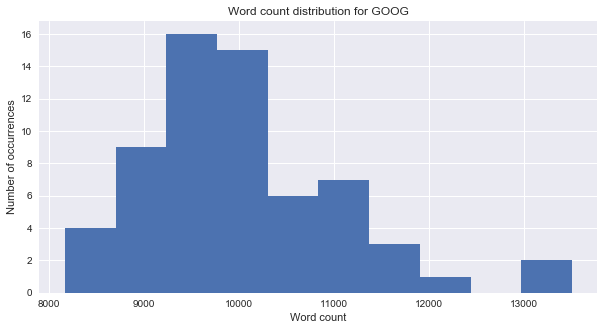

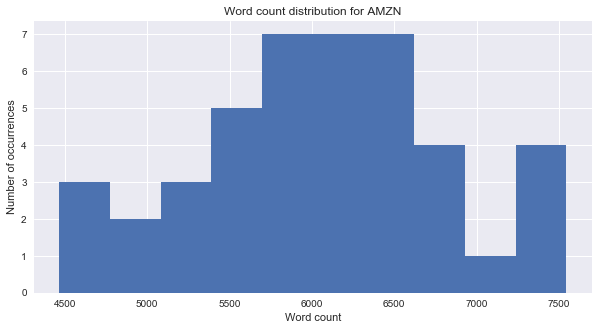

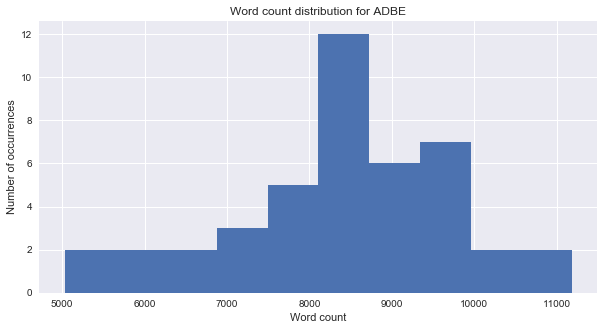

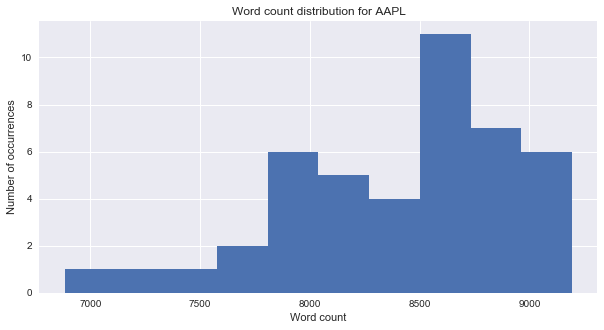

In [24]:
# Plot histogram of word counts for company transcripts
def visualize_word_count(transcripts):
    '''
    Plots a histogram of a company's transcript word counts.
    
    Args:
        transcripts: A Pandas DataFrame containing a company's history of earnings calls.
    '''
    
    company = transcripts['company'][0]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(transcripts['count'])
    plt.title("Word count distribution for {}".format(company))
    ax.set_xlabel('Word count')
    ax.set_ylabel('Number of occurrences')

for company in transcript_samples:
    visualize_word_count(company)

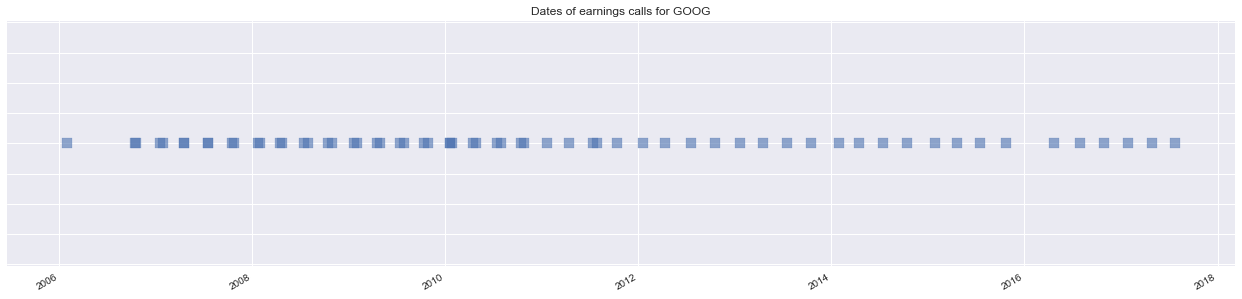

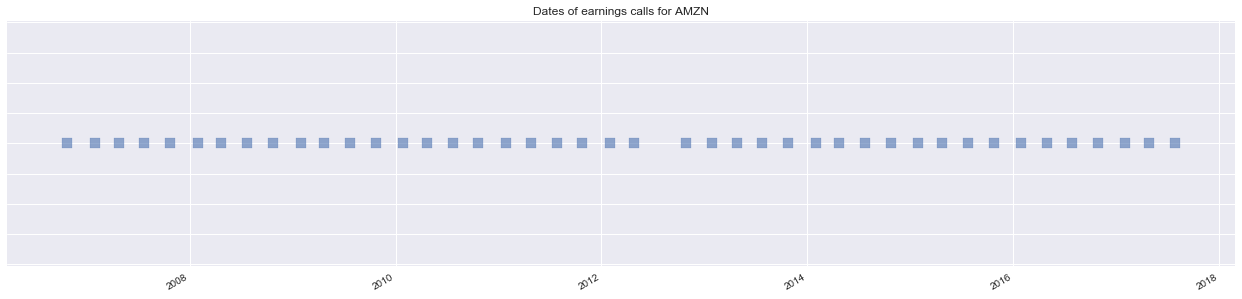

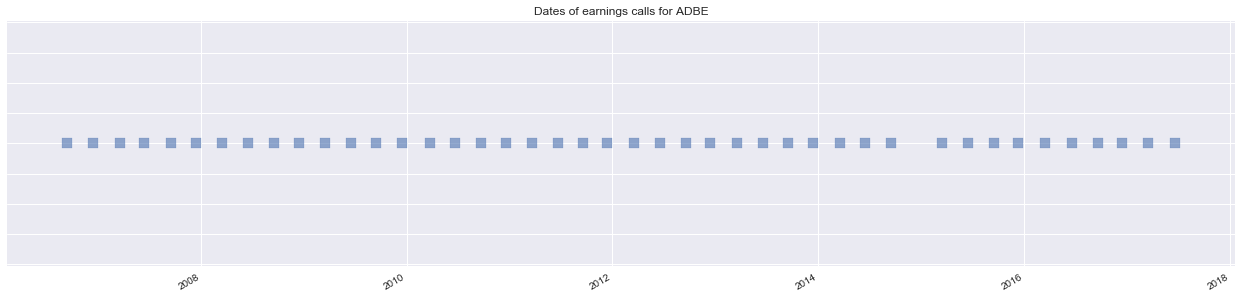

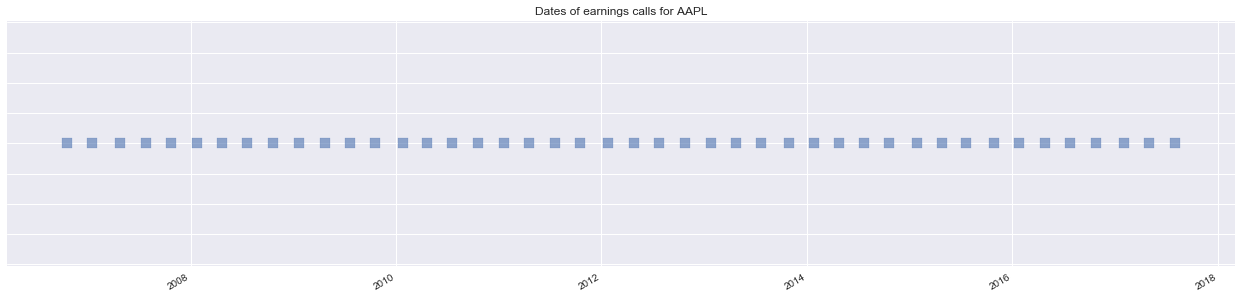

In [25]:
# Visualize transcript dates
def visualize_dates(transcripts):
    '''
    Plots the dates of a company's earning calls.
    
    Args:
        transcripts: A Pandas DataFrame containing a company's history of earnings calls.
    '''
    
    company = transcripts['company'][0]
    fig, ax = plt.subplots(figsize=(22,5))
    ax.scatter(transcripts.index, np.ones(len(transcripts.index)), marker = 's', alpha=0.6, s=100)
    fig.autofmt_xdate()
    ax.set_title("Dates of earnings calls for {}".format(company))
    ax.set_yticklabels([])

for company in transcript_samples:
    visualize_dates(company)

### Visualize loaded price data

2017-09-18 10:34:58,927 - DEBUG - Reading company prices for ALL
2017-09-18 10:34:58,932 - DEBUG - Reading company prices for CTL
2017-09-18 10:34:58,937 - DEBUG - Reading company prices for ABBV
2017-09-18 10:34:58,941 - DEBUG - Reading company prices for AMP
2017-09-18 10:34:58,945 - DEBUG - Reading company prices for AMG
2017-09-18 10:34:58,948 - DEBUG - Reading company prices for CMG
2017-09-18 10:34:58,951 - DEBUG - Reading company prices for HRB
2017-09-18 10:34:58,954 - DEBUG - Reading company prices for DRI
2017-09-18 10:34:58,957 - DEBUG - Reading company prices for DLTR
2017-09-18 10:34:58,960 - DEBUG - Reading company prices for CTAS
2017-09-18 10:34:58,964 - DEBUG - Reading company prices for CME
2017-09-18 10:34:58,967 - DEBUG - Reading company prices for C
2017-09-18 10:34:58,970 - DEBUG - Reading company prices for BCR
2017-09-18 10:34:58,974 - DEBUG - Reading company prices for ABC
2017-09-18 10:34:58,977 - DEBUG - Reading company prices for AON
2017-09-18 10:34:58,979 

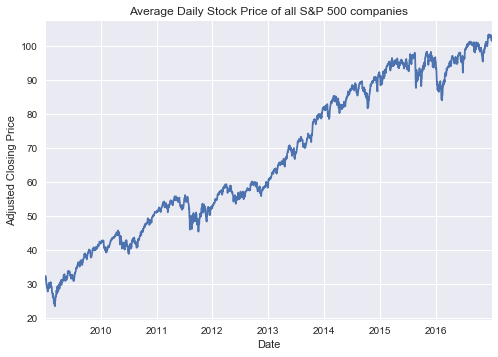

In [26]:
# Average value of all S&P 500 companies
all_companies = load_company_price_history(company_both, normalize=False)
all_companies.mean(axis=1).plot()
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.title('Average Daily Stock Price of all S&P 500 companies')

2017-09-18 10:35:00,094 - DEBUG - Reading company prices for GOOG
2017-09-18 10:35:00,149 - INFO - Null values found after cleaning: False


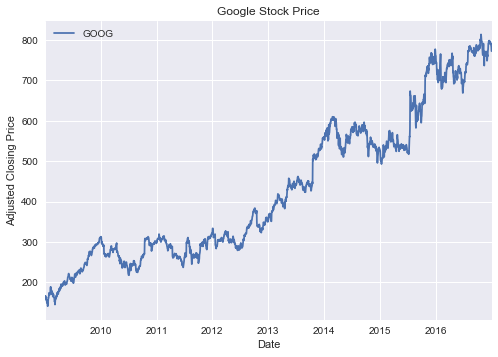

In [27]:
google_true_prices = load_company_price_history(['GOOG'])
google_true_prices.plot()
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.title('Google Stock Price')

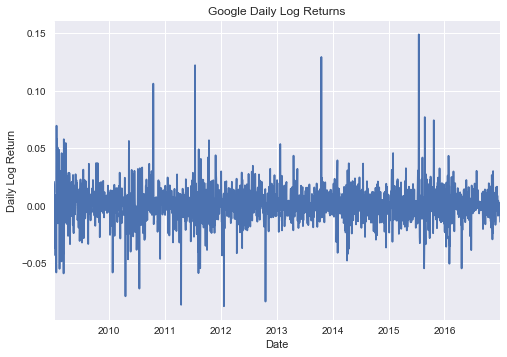

In [709]:
google_prices.plot()
plt.xlabel('Date')
plt.ylabel('Daily Log Return')
plt.title('Google Daily Log Returns')

In [29]:
price_samples.head(10)

,GOOG,AMZN,ADBE,AAPL
2009-01-02,0.020718,-0.005534,0.004767,0.041562
2009-01-05,0.020718,-0.005534,0.004767,0.041562
2009-01-06,0.018143,0.059253,0.046048,-0.016418
2009-01-07,-0.036745,-0.020430,0.000413,-0.022063
2009-01-08,0.009837,0.016938,0.002473,0.018293
2009-01-09,-0.031584,-0.029291,-0.011594,-0.022919
2009-01-12,-0.007590,-0.066859,-0.010467,-0.021086
2009-01-13,0.005173,-0.009094,-0.072426,-0.011111
2009-01-14,-0.043413,-0.059253,-0.045831,-0.027510
2009-01-15,-0.006540,0.059058,-0.013353,-0.023238


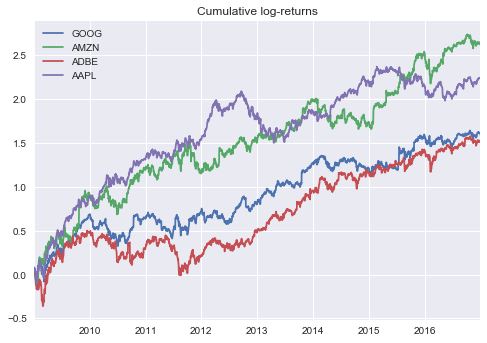

In [30]:
cum_returns = price_samples.cumsum()
cum_returns.plot()
plt.title('Cumulative log-returns')

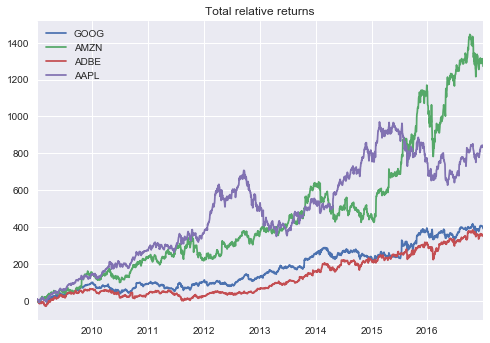

In [31]:
tot_rel_returns = 100*(np.exp(price_samples.cumsum()) - 1)
tot_rel_returns.plot()
plt.title('Total relative returns')

### Comparing price data with earnings call events

In [18]:
google_price_sample = load_company_price_history(['GOOG'])['2012':'2015']
google_returns_sample = load_company_price_history(['GOOG'], normalize=True)['2012':'2015']
google_transcript_sample = load_company_transcripts('GOOG')['2012':'2015']

2017-09-19 20:26:57,937 - DEBUG - Reading company prices for GOOG
2017-09-19 20:26:57,996 - INFO - Null values found after cleaning: False
2017-09-19 20:26:57,998 - DEBUG - Reading company prices for GOOG
2017-09-19 20:26:58,050 - INFO - Null values found after cleaning: False
2017-09-19 20:26:58,052 - DEBUG - Reading company transcripts for GOOG
2017-09-19 20:26:58,093 - WARNING - 1 duplicates removed from file


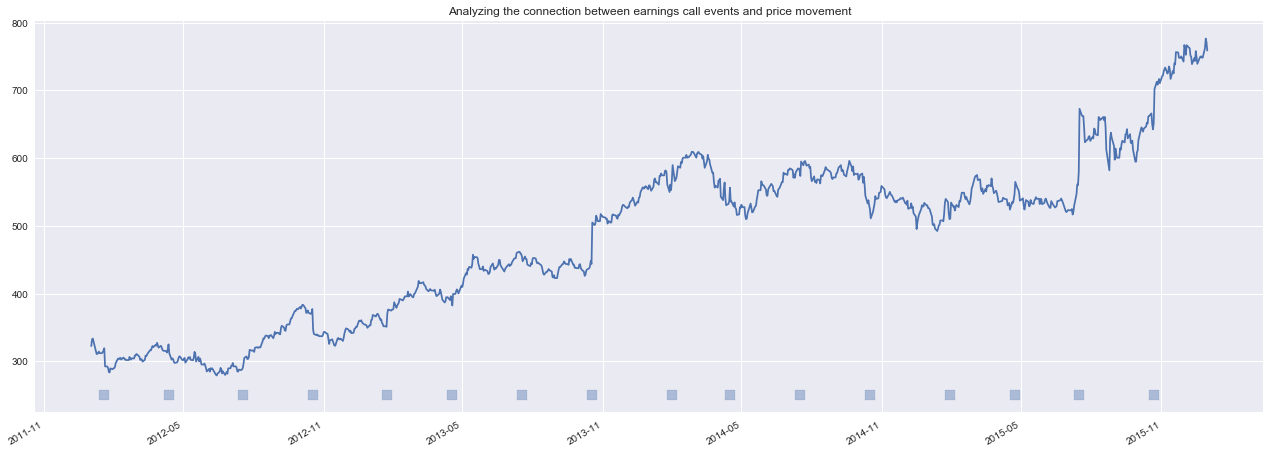

In [17]:
def plot_price_and_text(prices, transcripts):
    '''
    Plots the dates of a company's earning calls on top of a chart of the company's stock price.
    
    Args:
        prices: A Pandas DataFrame containing a company's price history. 
        transcripts: A Pandas DataFrame containing a company's history of earnings calls.
    '''
    # Plot the transcript events below the price, 10% offset from min price
    event_level = int(prices.min()*0.9) 
    fig, ax = plt.subplots(figsize=(22,8))
    ax.scatter(transcripts.index, event_level*np.ones(len(transcripts.index)), marker = 's', alpha=0.4, s=100)
    ax.plot(prices.index, prices)
    fig.autofmt_xdate()
    ax.set_title('Analyzing the connection between earnings call events and price movement')
    
plot_price_and_text(google_price_sample, google_transcript_sample)

### Explore connection between text events and returns

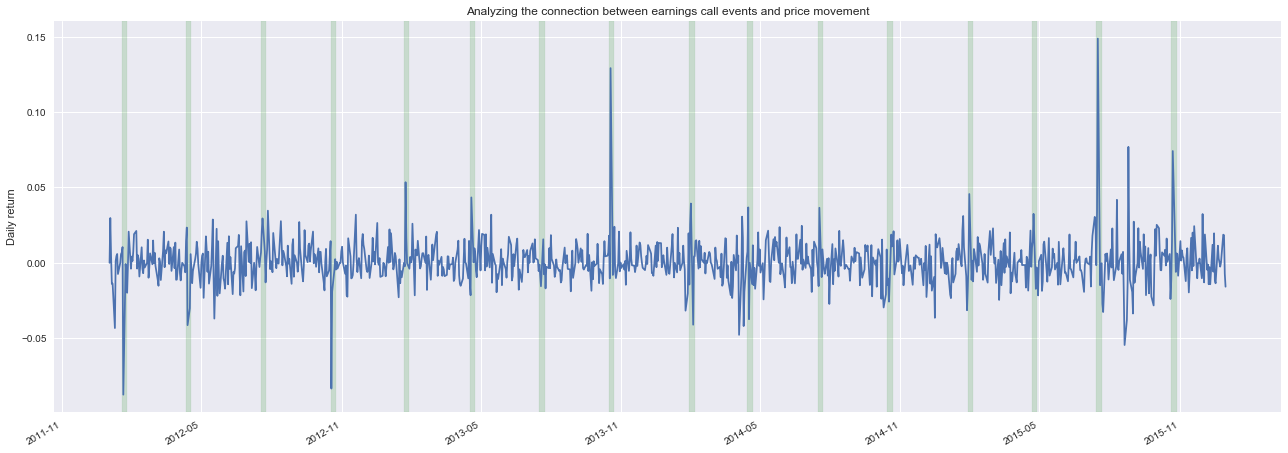

In [708]:
def plot_returns_and_text(returns, transcripts):
    '''
    Plots the dates of a company's earning calls on top of a chart of the company's daily returns.
    
    Args:
        prices: A Pandas DataFrame containing a company's price history. 
        transcripts: A Pandas DataFrame containing a company's history of earnings calls.
    '''
    # Plot the transcript events below the price, 10% offset from min price
    event_level = int(returns.min()*0.9) 
    fig, ax = plt.subplots(figsize=(22,8))
    #ax.scatter(transcripts.index, 0.1*np.ones(len(transcripts.index)), marker = 's', alpha=0.4, s=100)
    ax.plot(returns.index, returns)
    for date in transcripts.index:
        ax.axvspan(date - pd.to_timedelta('1 days'), date + pd.to_timedelta('6 days'), color='green', alpha=0.15)
    fig.autofmt_xdate()
    ax.set_title('Analyzing the connection between earnings call events and price movement')
    ax.set_ylabel('Daily return')

plot_returns_and_text(google_returns_sample, google_transcript_sample)

2017-09-22 09:03:46,754 - DEBUG - Reading company prices for CMG
2017-09-22 09:03:46,809 - INFO - Null values found after cleaning: False
2017-09-22 09:03:46,815 - DEBUG - Reading company transcripts for CMG
2017-09-22 09:03:46,907 - WARNING - 1 duplicates removed from file


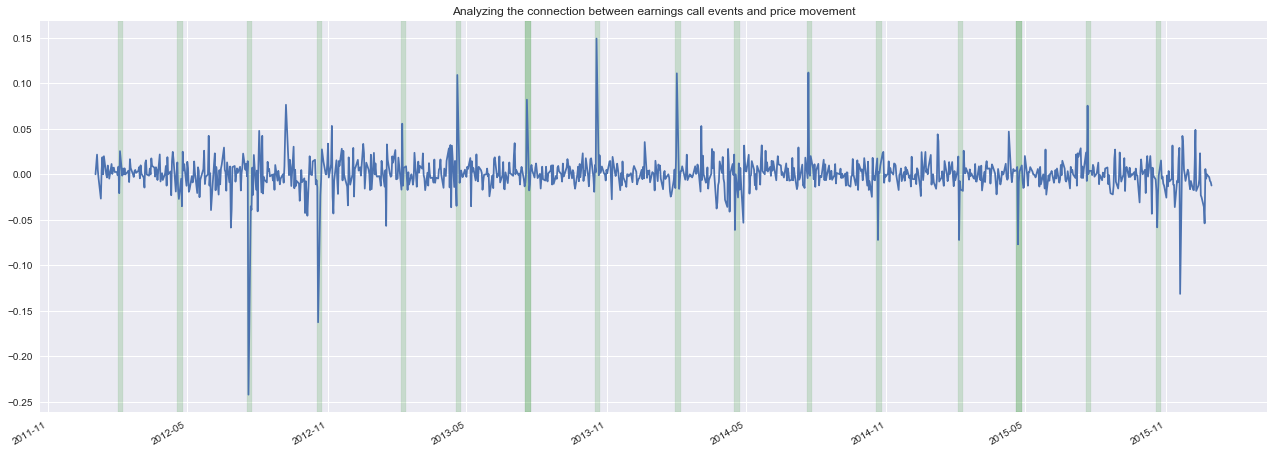

In [705]:
plot_returns_and_text(load_company_price_history(['CMG'], normalize=True)['2012':'2015'],
                      load_company_transcripts('CMG')['2012':'2015'])

Clearly, we can see some examples of large price movements surrounding the time of quarterly earnings calls. The goal of this project is to develop an algorithm capable of learning the price movements associated with the content of an earnings call.

<a id='step4'></a>
## Turning a thousand words into a picture with word embeddings

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* **[Step 4](#step4): Convert text to word embeddings**
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model



[Back to top](#step0)

For this project, I'll opt to use pretrained word embeddings. Namely, I'll use the GloVe (Global Vectors for Word Representation) embeddings presented [here](http://nlp.stanford.edu/projects/glove/). The embedding technique is based on factorizing a matrix of word co-occurence statistics. The GloVe embeddings data has vector representations for 400K words (computed on English Wikipedia) in 50 dimensions, 100 dimensions, 200 dimensions, and 300 dimensions. The embeddings are available to download [here](http://nlp.stanford.edu/data/glove.6B.zip) (file size: 822MB).

I may also try to use Facebook's FastText embeddings presented [here](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) and compare performance between the two embeddings; however, the embeddings file is much larger (9 GB) and likely not suitable for use on my local machine... so maybe I won't try this. 

For more advanced text processing, I could use spaCy. However, I'll hold that off until later. 

_**Useful resources:**_
* [Deep Learning, NLP, and Representations](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)

In [10]:
with open('glove.6B/glove.6B.50d.txt') as words:
    w2v = {word.split()[0]: np.vectorize(lambda x: float(x))(word.split()[1:]) for word in words}

logging.info('{} words in word2vec dictionary.'.format(len(w2v)))

# We'll later reduce the dimensionality from 50 to 2, let's go ahead and fit the entire corpus
# I've opted to use PCA over t-SNE given that we can fit the transformer once and have deterministic results
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(list(w2v.values()))
w2v_reduced = dict(zip(list(w2v.keys()), reduced_embeddings.tolist()))

2017-10-04 09:55:50,937 - INFO - 400000 words in word2vec dictionary.


Above, we've created a dictionary where the keys represent words in our vocabulary and the values are the vector representations of a given word. 

The 50-dimension vector representation of a word can be accessed by querying the dictionary. 

We've also went ahead and projected the 50-dimensional vectors into 2-dimensions for easier visualization. 

In [11]:
w2v['example']

array([ 0.51564  ,  0.56912  , -0.19759  ,  0.0080456,  0.41697  ,
        0.59502  , -0.053312 , -0.83222  , -0.21715  ,  0.31045  ,
        0.09352  ,  0.35323  ,  0.28151  , -0.35308  ,  0.23496  ,
        0.04429  ,  0.017109 ,  0.0063749, -0.01662  , -0.69576  ,
        0.019819 , -0.52746  , -0.14011  ,  0.21962  ,  0.13692  ,
       -1.2683   , -0.89416  , -0.1831   ,  0.23343  , -0.058254 ,
        3.2481   , -0.48794  , -0.01207  , -0.81645  ,  0.21182  ,
       -0.17837  , -0.02874  ,  0.099358 , -0.14944  ,  0.2601   ,
        0.18919  ,  0.15022  ,  0.18278  ,  0.50052  , -0.025532 ,
        0.24671  ,  0.10596  ,  0.13612  ,  0.0090427,  0.39962  ])

In [12]:
w2v_reduced['example']

[4.092878121172412, 1.785939893037579]

In [14]:
# Sample transcripts from collection
sample_text_google = google_transcripts['body'][5]
sample_text_amazon = amazon_transcripts['body'][5]
sample_text_adobe = adobe_transcripts['body'][5]

Let's see what words were ignored when we translate the transcripts to word embeddings. 

In [15]:
from keras.preprocessing.text import text_to_word_sequence

not_in_vocab = set([word for word in text_to_word_sequence(sample_text_google) if word not in w2v])
print('  --  '.join(not_in_vocab))

motofone  --  segment's  --  we're  --  ml910  --  here's  --  we've  --  doesn't  --  didn't  --  ed's  --  z6  --  asp's  --  vhub  --  p2k  --  weren't  --  you're  --  3gq  --  i'll  --  ray's  --  wasn't  --  they're  --  what's  --  i'd  --  motowi4  --  world's  --  embracement  --  downish  --  broadbus  --  hereon  --  devices'  --  shippable  --  w355  --  motorola's  --  w205  --  that’s  --  isn't  --  morning's  --  mw810  --  wimax's  --  that's  --  wouldn't  --  ounjian  --  let's  --  w215  --  dan's  --  motoming  --  organization's  --  krzr  --  reprioritizing  --  w510  --  mc50  --  greg's  --  today's  --  mc70  --  terry's  --  we'll  --  company's  --  don't  --  5ish  --  haven't  --  kvaal  --  you've  --  you'll  --  can't  --  nottenburg  --  motorokr  --  what’s  --  mc35  --  i've  --  metlitsky  --  there's  --  july's  --  w370  --  i'm  --  it's  --  motorizr


As you can see, our word embeddings dictionary doesn't support conjunctions. However, this should be alright seeing as most of them would likely be considered stopwords anyways.

A note on stopwords, these are words that are very commonly used and their presence does little to convey a unique signature of a body of text. They're useful in everyday conversations, but when you're identifying text based on the frequency of words used, they're next to useless. 

### TF-IDF weighting

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def get_tfidf_values(documents, norm=None):
    ''' 
    Transforms a collection of text documents into a collection of dictionaries mapping words to TFIDF values.
    
    Args:
        documents: An iterable which yields either str, unicode or file objects.
        norm: ‘l1’, ‘l2’ or None. Norm used to normalize term vectors. None for no normalization.
        
    Returns:
        A list of dictionaries containing mappings from words to TF-IDF scores for each document.
    '''
    count_vec = CountVectorizer()
    counts = count_vec.fit_transform(documents)
    words = np.array(count_vec.get_feature_names())
    
    transformer = TfidfTransformer(norm=norm)
    tfidf = transformer.fit_transform(counts)
    tfidf_arr = tfidf.toarray()
    
    tfidf_documents = []
    for i in range(len(documents)):
        tfidf_doc = {}
        for word, tfidf in zip(words[np.nonzero(tfidf_arr[i, :])], tfidf_arr[i, :][np.nonzero(tfidf_arr[i, :])]):
            tfidf_doc[word] = tfidf
        tfidf_documents.append(tfidf_doc)
    return tfidf_documents

In [17]:
def docs_to_3D(tfidf_documents, w2v_reduced):
    '''
    Transforms a list of dictionaries (word:tf-idf score) into a list of Pandas DataFrames containing
    word embedding dimensions (2) and TF-IDF score. 
    
    Args:
        tfidf_documents: A list of dictionaries containing mappings from words to TF-IDF scores for each document.
        w2v_reduced: A dictionary mapping words to their 2D embedding. 
        
    Returns:
        A list of DataFrames where each DataFrame contains the vocabulary and its features of a transcript.
    '''
    text_docs_3D = []
    
    for i, doc in enumerate(tfidf_documents): # list of documents with word:tfidf
        data = []
        for k, v in tfidf_documents[i].items():
            try:
                item = w2v_reduced[k][:] # Copy values from reduced embedding dictionary
                item.append(v) # Append the TFIDF score
                item.append(k) # Append the word
                data.append(item) # Add [dim1, dim2, tfidf, word] to collection
            except: # If word not in embeddings dictionary
                continue 

        df = pd.DataFrame(data, columns=['dim1', 'dim2', 'tfidf', 'word'])
        df = df.set_index(['word'])

        text_docs_3D.append(df)
        
    return text_docs_3D

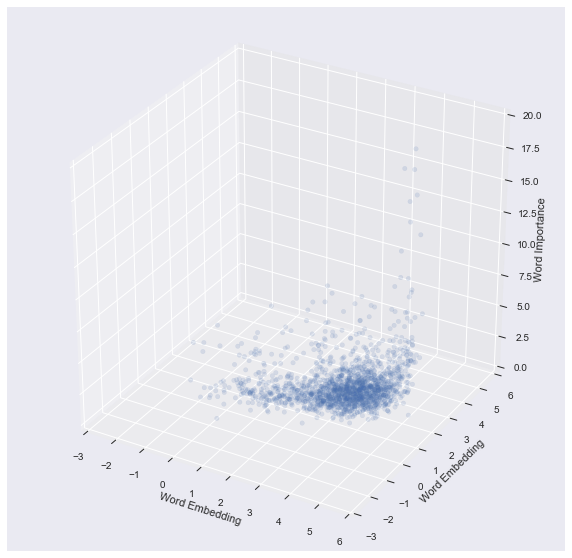

In [18]:
from mpl_toolkits.mplot3d import Axes3D

tfidf_docs = get_tfidf_values(google_transcripts['body'])
text_docs_3D = docs_to_3D(tfidf_docs, w2v_reduced)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3, 6])
ax.set_ylim([-3, 6])
ax.set_zlim([0, 20])
ax.set_xlabel('Word Embedding')
ax.set_ylabel('Word Embedding')
ax.set_zlabel('Word Importance')

text = text_docs_3D[0]
scatter = ax.scatter(text['dim1'], text['dim2'], text['tfidf'].apply(np.sqrt), alpha=0.15,
                     zdir='z', s=20, c=None, depthshade=True)

(array([ 911.,  679.,   88.,   15.,   12.,    3.,    2.,    1.,    2.,    2.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

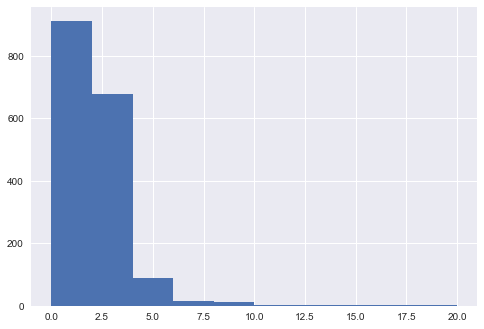

In [113]:
plt.hist(text_docs_3D[0]['tfidf'].apply(np.sqrt), range=(0,20))

### Evolution of company transcripts over time

Enhancement: rather than providing a list of word embedding vectors to plot, pass a dictionary of word:vector pairs so that user can hover mouse over points to see what words are. 

In [19]:
from matplotlib import rc
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [20]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def animate_company_transcripts_3D(vis_docs):
    '''Accepts a reduced (2D) vector representation of a collection of
    text documents with TDIDF scores and animates the visual evolution of text over time.
    
    Optional: include date labels in plot.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim([-3, 6])
    ax.set_ylim([-3, 6])
    ax.set_zlim([0, 20])
    ax.set_xlabel('Word Embedding')
    ax.set_ylabel('Word Embedding')
    ax.set_zlabel('Word Importance')

    text = vis_docs[0]
    scatter = ax.scatter(text['dim1'], text['dim2'], text['tfidf'], alpha=0.1, 
                         zdir='z', s=20, c=None, depthshade=True, animated=True)

    def update(frame_number):
        text = vis_docs[frame_number]
        scatter._offsets3d = (text['dim1'], text['dim2'], text['tfidf'].apply(np.sqrt))
        return scatter

    return FuncAnimation(fig, update, frames=len(vis_docs), interval=300, repeat=True)

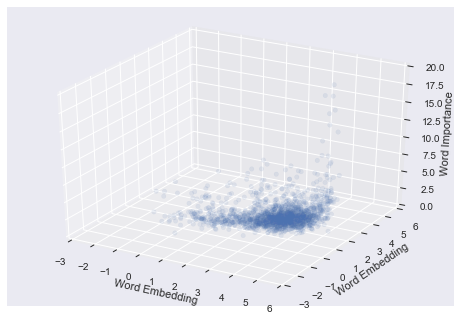

In [21]:
tfidf_docs = get_tfidf_values(google_transcripts['body'])
text_docs_3D = docs_to_3D(tfidf_docs, w2v_reduced)
animate_company_transcripts_3D(text_docs_3D)

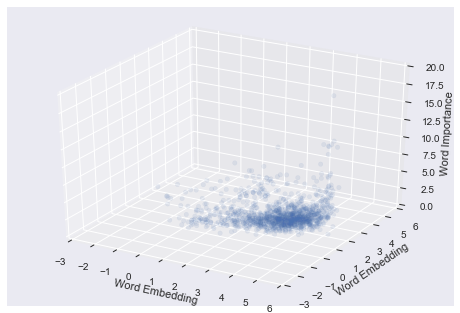

In [22]:
tfidf_docs = get_tfidf_values(apple_transcripts['body'])
text_docs_3D = docs_to_3D(tfidf_docs, w2v_reduced)
animate_company_transcripts_3D(text_docs_3D)

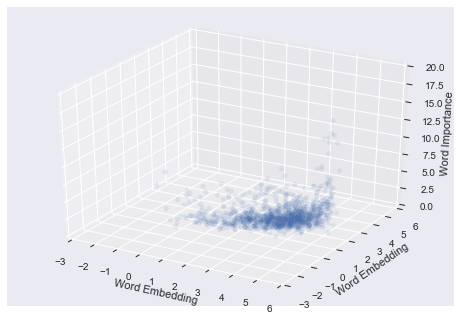

In [23]:
tfidf_docs = get_tfidf_values(amazon_transcripts['body'])
text_docs_3D = docs_to_3D(tfidf_docs, w2v_reduced)
animate_company_transcripts_3D(text_docs_3D)

### Digitize input space for ConvNet

In [502]:
def digitize_embedding_space(text_docs_3D, index, bins=250):
    '''
    Accepts a list of DataFrames where each DataFrame contains the vocabulary and its features of a transcript,
    binning each DataFrame vocabulary into a 2D array, where the bin values correspond with the sum of TF-IDF
    weights for all words assigned to the bin. 
    
    Args:
        text_docs_3D: A list of DataFrames where each DataFrame contains the vocabulary and its features of a 
        transcript.
        index: The index of the original transcripts DataFrame where index values correspond with the dates
        of the earnings call. These dates are important to preserve. 
        bins: Defines the dimensions of the 2D array used as input into the ConvNet feature extractor. 
        
    Returns:
        text_docs: A list of 2D arrays, ready for input. 
        lookup: A Pandas Series mapping the `text_docs` list indicies to their corresponding dates. 
    '''
    
    binned_docs = []
    for frame, data in enumerate(text_docs_3D):
        doc = text_docs_3D[frame]

        # Sort collection of word embeddings in continous vector space to a 2D array of bins. Take square root of 
        # TF-IDF score as a means of scaling values to prevent a small number of terms from being too dominant.
        hist = np.histogram2d(doc['dim1'], doc['dim2'], weights=doc['tfidf'].apply(np.sqrt), bins=bins)[0]
        binned_docs.append(hist)

    # Technically, you shouldn't store numpy arrays as a Series
    # Somehow, I was able to hack my way around that, but when you try to reindex the Series it throws an error
    # It was convenient to use the Series groupby function, though
    # NOTE: This should be revisited at some point using xarray or some other more suitable data store
    text_3D = pd.Series(binned_docs, index=index)

    # Combine same-day events
    if text_3D.index.duplicated().sum() > 0:
        logging.info('{} same-day events combined.'.format(text_3D.index.duplicated().sum()))
    text_3D = text_3D.groupby(text_3D.index).apply(np.mean)
    
    # Now I'll convert the Series of numpy 2d arrays into a list of numpy 2d array (losing the date index)
    # and create another Series that ties the date to the list index of text_docs 
    text_docs = text_3D.values.tolist()
    lookup = pd.Series(range(len(text_docs)), index = text_3D.index)
    
    return text_docs, lookup

### Develop full text processing pipeline

In [483]:
def process_text_for_input(documents, w2v_reduced, norm=None):
    '''
    Full text preprocessing pipeline to convert DataFrames of text into input for the ConvNet.
    
    Args:
        documents: An iterable which yields either str, unicode or file objects.
        w2v_reduced: A dictionary mapping words to their 2D embedding.
        norm: ‘l1’, ‘l2’ or None. Norm used to normalize term vectors. None for no normalization.
        
    Returns:
        text_docs: A list of 2D arrays, ready for input. 
        lookup: A Pandas Series mapping the `text_docs` list indicies to their corresponding dates. 
    '''
    index = documents.index
    tfidf_docs = get_tfidf_values(documents, norm=norm)
    text_docs_3D = docs_to_3D(tfidf_docs, w2v_reduced)
    text_docs, lookup = digitize_embedding_space(text_docs_3D, index)
    return text_docs, lookup

In [25]:
# Test out pre-processing pipeline
text_docs, lookup = process_text_for_input(google_transcripts['body'], w2v_reduced)

2017-09-19 17:28:52,774 - INFO - 2 same-day events combined.


<a id='step5'></a>
## Benchmark ARIMA Model

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* **[Step 5](#step5): Benchmark ARIMA model**
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model


###### Useful resources:
* [Jeffrey Yau | Applied Time Series Econometrics in Python and R](https://www.youtube.com/watch?v=tJ-O3hk1vRw) and [Github repo](https://github.com/silicon-valley-data-science/pydata-sf-2016-arima-tutorial/blob/master/)
* [Stock Price Forecasting Using Information from Yahoo Finance and Google Trend - Selene Yue Xu (UC Berkeley)](https://www.econ.berkeley.edu/sites/default/files/Selene%20Yue%20Xu.pdf)
* [A Guide to Time Series Forecasting with ARIMA in Python 3 - Digital Ocean](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
* [ARIMA models for time series forecasting - Duke University](https://people.duke.edu/~rnau/411arim.htm)
* [Forecasting Stock Returns using ARIMA model - Quantinsti](https://www.quantinsti.com/blog/forecasting-stock-returns-using-arima-model/)
* [Stats models SARIMAX documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
* [Forecasting Stock Returns using ARIMA model - R bloggers](https://www.r-bloggers.com/forecasting-stock-returns-using-arima-model/)





[Back to top](#step0)

### Exploring statistical properties of the data

In [620]:
# Note: this cell was copied from source as cited. 

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0, lags) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [63]:
# Load a few companies for inspection
company_price_ARIMA = load_company_price_history(['GOOG', 'AAPL', 'AMZN', 'CA', 'MMM'])

# Select a company and sample a two year time period, reindexing to have a uniform frequency
google_price_ARIMA = company_price_ARIMA['GOOG']['2012':'2013']

apple_price_ARIMA = company_price_ARIMA['AAPL']['2012':'2013']

logging.info("Index frequency: {}".format(google_price_ARIMA.index.freq))

2017-09-18 14:08:07,752 - DEBUG - Reading company prices for GOOG
2017-09-18 14:08:07,759 - DEBUG - Reading company prices for AAPL
2017-09-18 14:08:07,763 - DEBUG - Reading company prices for AMZN
2017-09-18 14:08:07,766 - DEBUG - Reading company prices for CA
2017-09-18 14:08:07,769 - DEBUG - Reading company prices for MMM
2017-09-18 14:08:07,831 - INFO - Null values found after cleaning: False
2017-09-18 14:08:07,834 - INFO - Index frequency: <BusinessDay>


(<matplotlib.axes._subplots.AxesSubplot at 0x115003198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117d4fa90>)

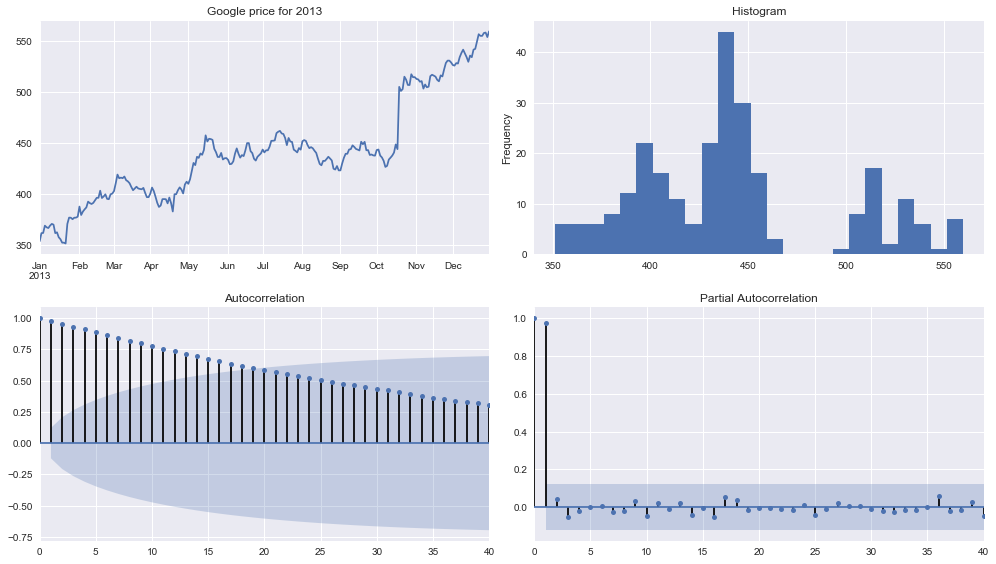

In [69]:
tsplot(google_price_ARIMA['2013'], title='Google price for 2013', lags =40)

(<matplotlib.axes._subplots.AxesSubplot at 0x10f4f7c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11094fcc0>)

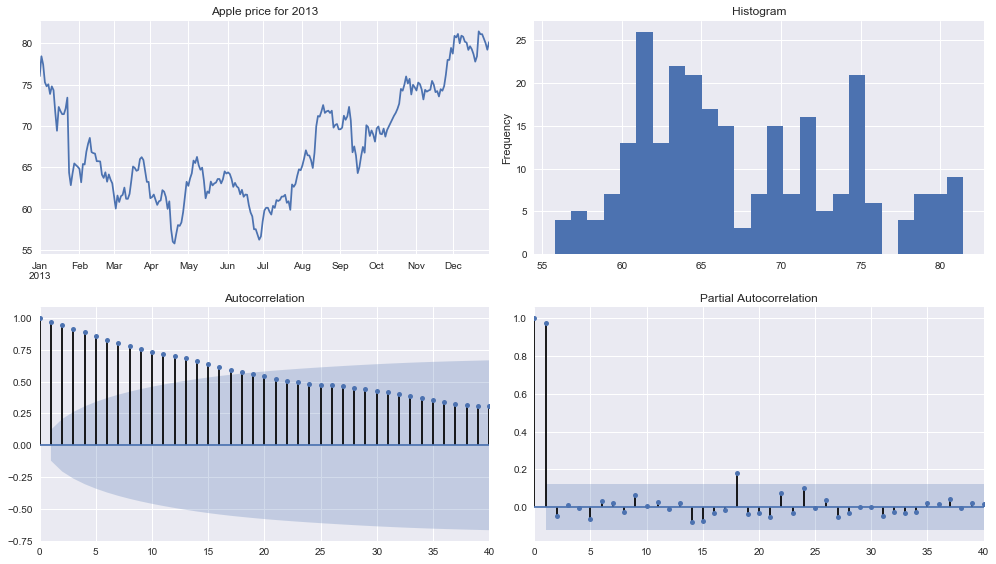

In [70]:
tsplot(apple_price_ARIMA['2013'], title='Apple price for 2013', lags = 40)

Looking at the autocorrelation plots, it appears that the time series data is highly dependent on its history, with autocorrelation extending many periods back in time. However, examining the partial autocorrelation plots, it is clear that almost all of the correlation stems from the timestep immediately prior. 

In [868]:
google_returns_2013 = np.log(google_price_ARIMA['2013']).diff()[1:]
apple_returns_2013 = np.log(apple_price_ARIMA['2013']).diff()[1:]

(<matplotlib.axes._subplots.AxesSubplot object at 0x1a42e44a8>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a471f908>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a47ac588>)

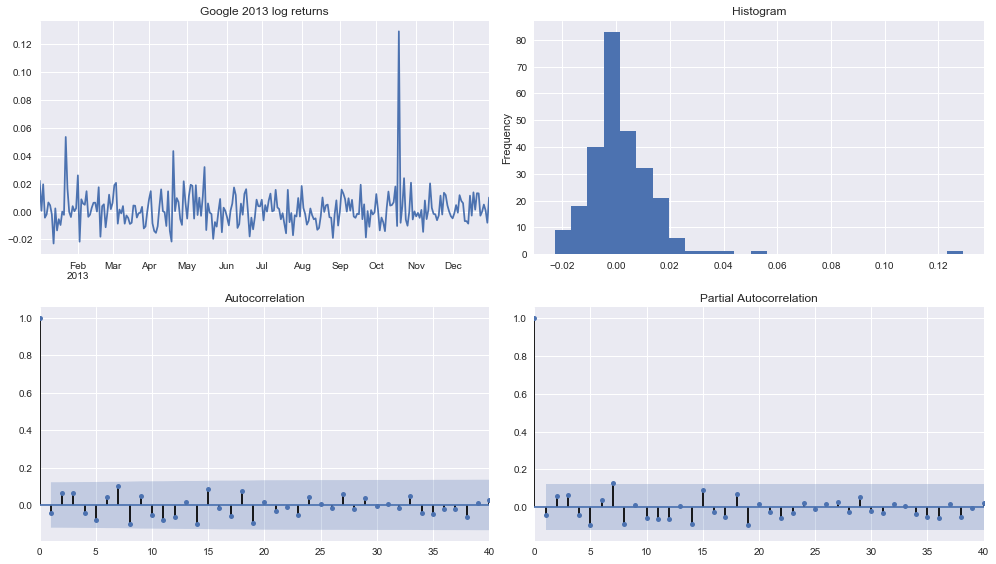

In [873]:
tsplot(google_returns_2013, title='Google 2013 log returns', lags = 40)

(<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f631d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a4233390>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a42bf320>)

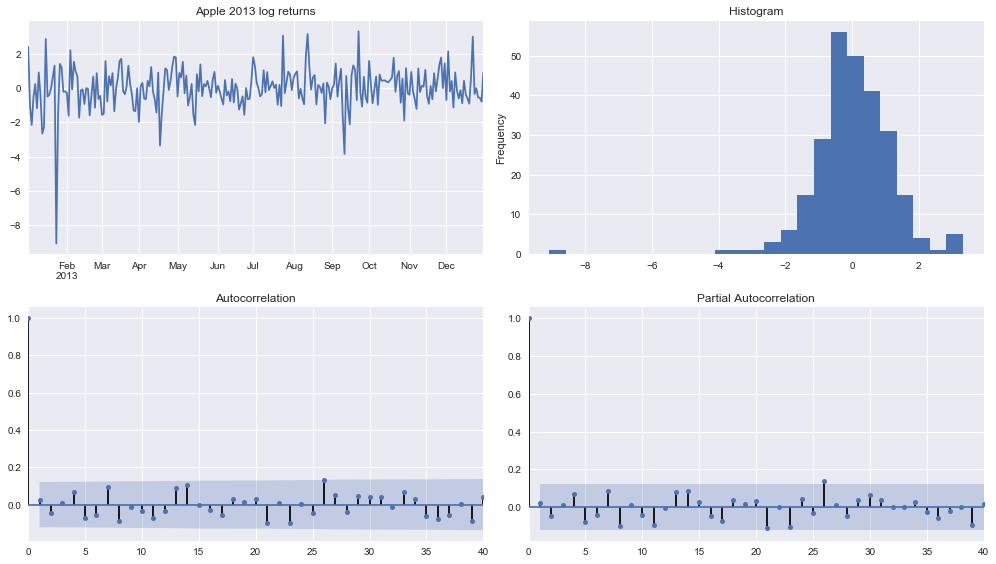

In [872]:
tsplot(apple_returns_2013, title='Apple 2013 log returns', lags = 40)

Note, first differencing appears to produce stationarity of the time series. Thus, we should enforce $d=1$. 

Returns appear to follow a random walk, where the current timestep is not correlated with any of the previous timesteps. This suggests an ARIMA(0,1,0) model, where the best prediction we can make it a constant value.
 
See Duke reference for guidance on analysis of time series with respect to ARIMA modeling. 

### Grid search for best ARIMA parameters

In [76]:
import itertools

import warnings
warnings.filterwarnings("ignore") # Ignore convergence warnings

def grid_search_SARIMA(y, pdq_min, pdq_max, seasonal_period):
    p = d = q = range(pdq_min, pdq_max+1)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    best_params = []
    best_seasonal_params = []
    score = 1000000000000 # this is a bit of a hack
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                logging.info('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                if results.aic < score:
                    best_params = param
                    best_seasonal_params = param_seasonal
                    score = results.aic
            except:
                continue
    logging.info('\n\nBest ARIMA{}x{}12 - AIC:{}'.format(best_params, best_seasonal_params, score))
    return best_params, best_seasonal_params, score


params, seasonal_params, score = grid_search_SARIMA(google_price_ARIMA, 0, 2, 12)

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6898.362293047701
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:6200.392463920813
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4377.816871987012
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:4278.05126125979
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:4276.299285445659
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:4176.806413694854
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4465.432601601324
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4446.857399572644
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:4320.115713978383
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4386.46212764317
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4376.855567398701
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:4279.127651774714
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:4454.8313975262445
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:4276.785787961944
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:4175.469208200152
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:4329.934376732559
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:4331.216630881858
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:4321.299433109684
ARIMA(0, 0,

### Fit a model and explore the results

In [271]:
mod = sm.tsa.statespace.SARIMAX(google_price_ARIMA,
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0166      0.055     -0.302      0.763      -0.124       0.091
ma.L2          0.0173      0.061      0.284      0.776      -0.102       0.137
ma.S.L12      -1.0085    117.970     -0.009      0.993    -232.226     230.209
ma.S.L24       0.0085      1.017      0.008      0.993      -1.985       2.002
sigma2        27.0053   3186.030      0.008      0.993   -6217.499    6271.510


In [272]:
pred = results.get_prediction(start = pd.to_datetime('2013-10-1'), end = pd.to_datetime('2013-12-31'), dynamic=False)
pred_ci = pred.conf_int()

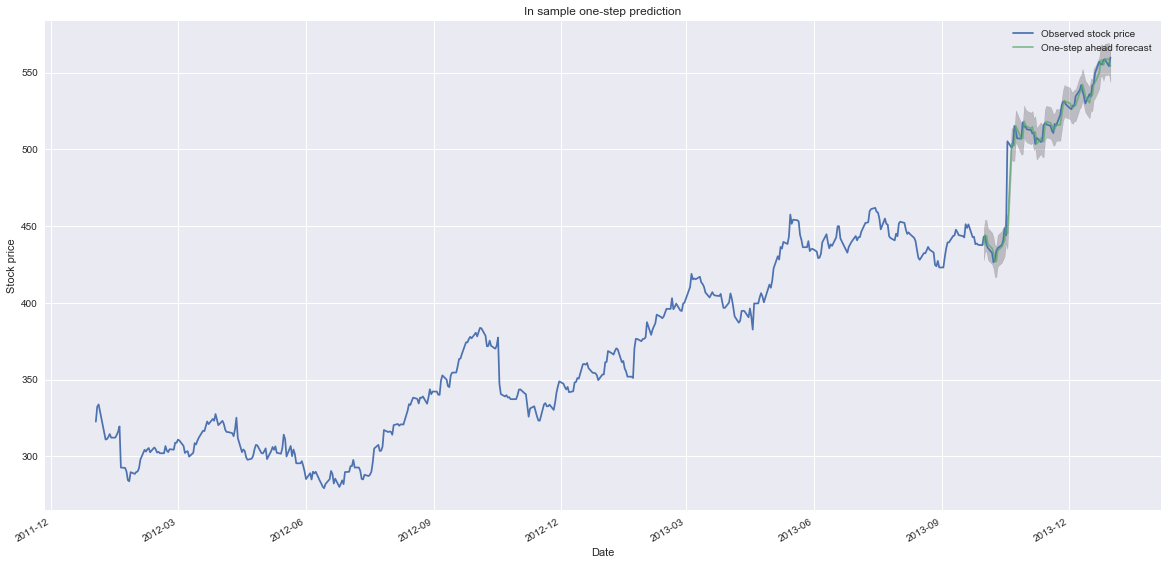

In [250]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(google_price_ARIMA.index, google_price_ARIMA, 
        label='Observed stock price')
ax.plot(pred.predicted_mean.index, pred.predicted_mean, 
        label='One-step ahead forecast', alpha=.7)
fig.autofmt_xdate()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Stock price')
ax.set_title('In sample one-step prediction')
plt.legend()

In [81]:
pred_dynamic = results.get_prediction(start = pd.to_datetime('2013-11-1'), dynamic=True, full_results=True)
pred_ci_dynamic = pred_dynamic.conf_int()

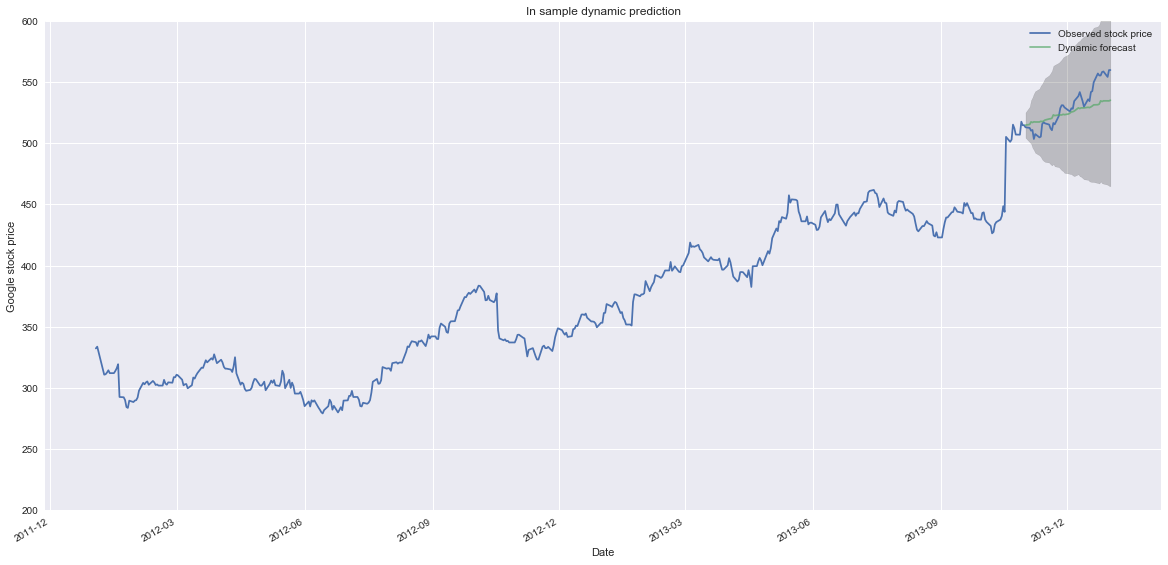

In [82]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(google_price_ARIMA.index, google_price_ARIMA, 
        label='Observed stock price')
ax.plot(pred_dynamic.predicted_mean.index, pred_dynamic.predicted_mean, 
        label='Dynamic forecast', alpha=.7)
fig.autofmt_xdate()
ax.fill_between(pred_ci_dynamic.index,
                pred_ci_dynamic.iloc[:, 0],
                pred_ci_dynamic.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Google stock price')
ax.set_title('In sample dynamic prediction')
ax.set_ylim(200,600)
plt.legend()

In [84]:
# Get forecast 500 steps ahead in future
pred_future = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_future_ci = pred_future.conf_int()

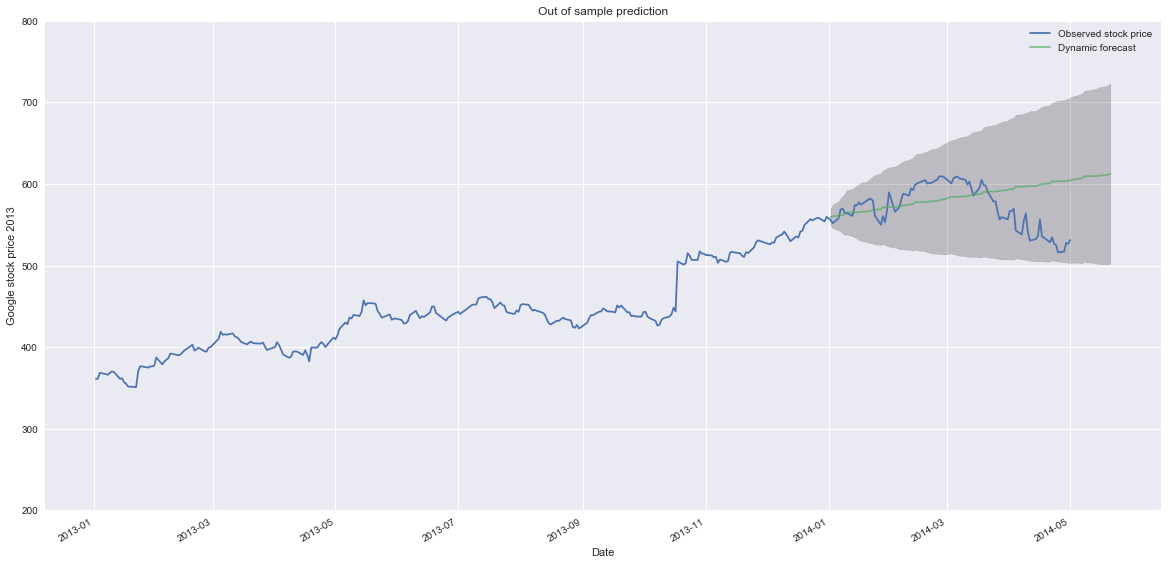

In [85]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(company_price_ARIMA['GOOG']['2013':'2014-05-01'].index, company_price_ARIMA['GOOG']['2013':'2014-05-01'], 
        label='Observed stock price')
ax.plot(pd.to_datetime(pred_future.predicted_mean.index), pred_future.predicted_mean, 
        label='Dynamic forecast', alpha=.7)
fig.autofmt_xdate()
ax.fill_between(pred_future_ci.index,
                pred_future_ci.iloc[:, 0],
                pred_future_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Google stock price 2013')
ax.set_title('Out of sample prediction')
ax.set_ylim(200,800)
plt.legend()

Training over multiple time series: https://stats.stackexchange.com/questions/23036/estimating-same-model-over-multiple-time-series

### Training

ARIMA models are not typically trained across time series unless the time series data is generated by the same process. For the case of stock prices, there exist independent influences on individual companies that does not uniformly affect all companies. Thus, 5 different ARIMA models will be trained for different companies, evaluating each model individually and averaging the result.  

In [665]:
google_arima_train = company_price_df['GOOG']['2009':'2012']
amazon_arima_train = company_price_df['AMZN']['2009':'2012']
mmm_arima_train = company_price_df['MMM']['2009':'2012']
chipotle_arima_train = company_price_df['CMG']['2009':'2012']
duke_arima_train = company_price_df['DUK']['2009':'2012']

companies_train = [google_arima_train, amazon_arima_train, mmm_arima_train, chipotle_arima_train, duke_arima_train]

google_arima_test = company_price_df['GOOG']['2013':'2014']
amazon_arima_test = company_price_df['AMZN']['2013':'2014']
mmm_arima_test = company_price_df['MMM']['2013':'2014']
chipotle_arima_test = company_price_df['CMG']['2013':'2014']
duke_arima_test = company_price_df['DUK']['2013':'2014']

companies_test = [google_arima_test, amazon_arima_test, mmm_arima_test, chipotle_arima_test, duke_arima_test]

In [666]:
company_results = []
for company_price in companies_train:
    model = sm.tsa.statespace.SARIMAX(company_price,
                                order=(0, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = model.fit()
    company_results.append(results)

### Evaluation

We'll evaluate each model on three timescales: a 5 day forecast, a 20 day forecast, and a 100 day forecast. Long-term prediction is very difficult, especially for stochastic processes; thus, the short-term forecast provides a more reasonable measure of performance.   

In [682]:
forecast_5_day = []
forecast_20_day = []
forecast_100_day = []

for result in company_results:
    forecast_5_day.append(result.get_forecast(steps=5))
    forecast_20_day.append(result.get_forecast(steps=20))
    forecast_100_day.append(result.get_forecast(steps=100))

In [683]:
from sklearn.metrics import mean_absolute_error

forecast_5_day_mae = []
for true, pred in zip(companies_test, forecast_5_day):
    forecast_5_day_mae.append(mean_absolute_error(true.iloc[0:5], pred.predicted_mean))
    
forecast_20_day_mae = []
for true, pred in zip(companies_test, forecast_20_day):
    forecast_20_day_mae.append(mean_absolute_error(true.iloc[0:20], pred.predicted_mean))
    
forecast_100_day_mae = []
for true, pred in zip(companies_test, forecast_100_day):
    forecast_100_day_mae.append(mean_absolute_error(true.iloc[0:100], pred.predicted_mean))
    
    
print('Average MAE across companies (5 day): {:.6f}'.format(np.mean(forecast_5_day_mae)))
print('Average MAE across companies (20 day): {:.6f}'.format(np.mean(forecast_20_day_mae)))
print('Average MAE across companies (100 day): {:.6f}'.format(np.mean(forecast_100_day_mae)))

Average MAE across companies (5 day): 0.009500
Average MAE across companies (20 day): 0.009690
Average MAE across companies (100 day): 0.009965


Let's examine what the long term predictions look like. 

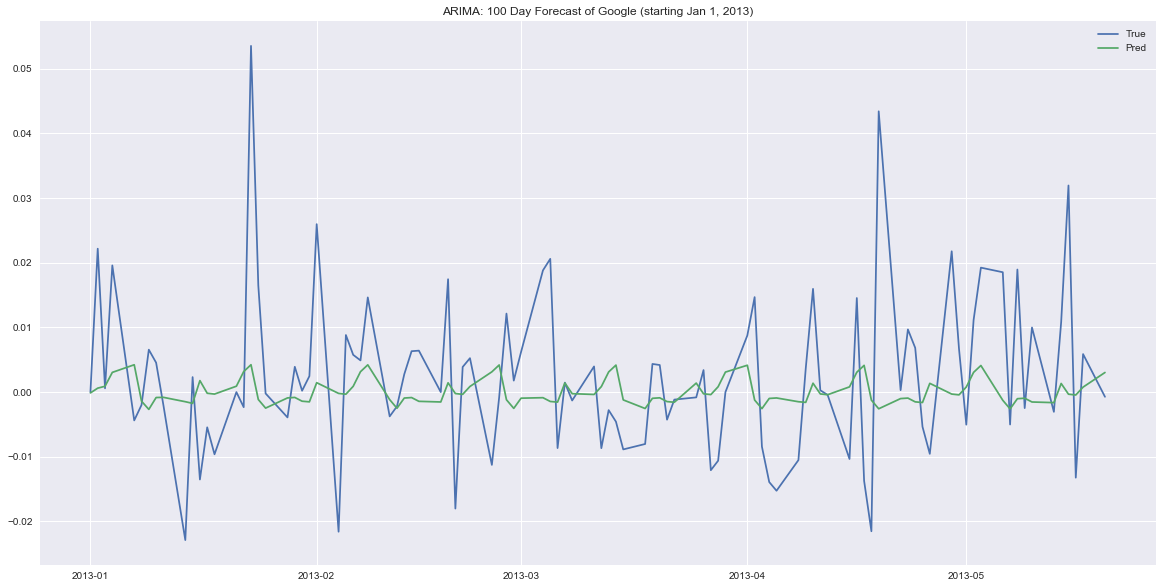

In [685]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(google_arima_test.iloc[0:100], label='True')
ax.plot(forecast_100_day[0].predicted_mean, label='Pred')
ax.set_title('ARIMA: 100 Day Forecast of Google (starting Jan 1, 2013)')
plt.legend()

<a id='step6'></a>
## LSTM Price Prediction

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* **[Step 6](#step6): Benchmark LSTM price model**
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model

_**Useful resources:**_
* [Understanding LSTM Networks - colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [How Recurrent Neural Networks and Long Short-Term Memory Work - brohrer](http://brohrer.github.io/how_rnns_lstm_work.html)
* [Advanced usage of recurrent neural networks - François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb)
* [Stanford CS231n Lecture 10 | Recurrent Neural Networks](https://www.youtube.com/watch?v=6niqTuYFZLQ&index=10&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv)
* [The Unreasonable Effectiveness of Recurrent Neural Networks - Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Improve Your Python: 'yield' and Generators Explained](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) (for building generators to feed batches of input to the network)


[Back to top](#step0)

### Data preparation

In [606]:
# Load a test company for inspection
LSTM_company_prices = load_company_price_history(['GOOG', 'AMZN', 'MMM', 'CMG', 'DUK'], normalize = True)

LSTM_prices_train = LSTM_company_prices['2009':'2012']
LSTM_prices_test = LSTM_company_prices['2013':'2014']
LSTM_prices_val = LSTM_company_prices['2015':'2016']

2017-09-20 22:09:46,753 - DEBUG - Reading company prices for GOOG
2017-09-20 22:09:46,759 - DEBUG - Reading company prices for AMZN
2017-09-20 22:09:46,763 - DEBUG - Reading company prices for MMM
2017-09-20 22:09:46,767 - DEBUG - Reading company prices for CMG
2017-09-20 22:09:46,771 - DEBUG - Reading company prices for DUK
2017-09-20 22:09:46,825 - INFO - Null values found after cleaning: False


In [607]:
def price_generator(data, window=180, batch_size=128):
    ''' Accepts price history as a numpy array of shape (timesteps, companies) and builds windows for input, output 
    pairs. Output is calculated as the t+1 timestep. 
    
    Training/validation/testing data must be split prior to this generator. 
    
    Args:
        data: Array of company(ies) price history with shape (timesteps, companies)
        window: Length to build input and output sequences. 
        batch_size: Number of samples to return for batch training. 
        
    Yields:
        input_prices: A sequence of prices: [t-window, t-window+1, t-window+2, ..., t-1]
        output_prices: A sequence of prices offset by one day: [t-window+1, t-window+2, t-window+3, ..., t] 
    '''
    
    timesteps = data.shape[0]
    companies = data.shape[1]
    
    if window + batch_size > timesteps:
        logging.warning('Not enough data to fill a batch, forcing smaller batch size.')
        batch_size = timesteps - window
    
    # Index to keep track of place within price timeseries, corresponds with the last day of output
    i = window
    
    # Index to keep track of which company to query the data from
    j = 0
    
    while True:
        # If there aren't enough sequential days to fill a batch, go to next company
        if i + batch_size >= timesteps:
            i = window
            
            # If end of companies has been reached, start back at first company
            if j+1 >= companies:
                j=0
            else:
                j+=1
            
        
        samples = np.arange(i, i + batch_size)
        i += len(samples)
        
        input_prices = np.zeros((batch_size, window, 1))
        output_prices = np.zeros((batch_size, window, 1))
        
        for k, sample in enumerate(samples):
            input_prices[k] = data[np.arange(sample-window, sample),j].reshape(window, 1)
            output_prices[k] = data[np.arange(sample-window+1, sample+1),j].reshape(window, 1)
        
        yield input_prices, output_prices

In [608]:
window_size = 180 
batch_size = 64

train_gen = price_generator(LSTM_prices_train.values, window=window_size, batch_size=batch_size)
train_steps = (LSTM_prices_train.shape[0] // batch_size)*LSTM_prices_train.shape[1]

val_gen = price_generator(LSTM_prices_val.values, window=window_size, batch_size=batch_size)
val_steps = (LSTM_prices_val.shape[0] // batch_size)*LSTM_prices_val.shape[1]

test_gen = price_generator(LSTM_prices_test.values, window=window_size, batch_size=batch_size)
test_steps = (LSTM_prices_test.shape[0] // batch_size)*LSTM_prices_test.shape[1]

### Build the model

In [609]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM


# define LSTM configuration
n_features = 1 # only price
window = 180 # look back 50 days
batch_size = 128

# create LSTM
price_only_model = Sequential()
price_only_model.add(LSTM(20, input_shape=(window, n_features), return_sequences=True))
price_only_model.add(LSTM(60, return_sequences=True))
price_only_model.add(TimeDistributed(Dense(1)))
print(price_only_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 180, 20)           1760      
_________________________________________________________________
lstm_8 (LSTM)                (None, 180, 60)           19440     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 180, 1)            61        
Total params: 21,261.0
Trainable params: 21,261
Non-trainable params: 0.0
_________________________________________________________________
None


In [611]:
from keras.callbacks import ModelCheckpoint 

price_only_model.compile(loss='mean_absolute_error', optimizer='adam')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.price_only.hdf5', 
                               verbose=1, save_best_only=True)

# Train LSTM
history = price_only_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=3, callbacks=[checkpointer], 
                                         validation_data=val_gen, validation_steps=val_steps)

Epoch 1/3
80/80 [==============================] - 85s - loss: 0.0121 - val_loss: 0.0108
Epoch 2/3
80/80 [==============================] - 79s - loss: 0.0125 - val_loss: 0.0109
Epoch 3/3
80/80 [==============================] - 79s - loss: 0.0117 - val_loss: 0.0108


In [645]:
# Load weights from previous training
price_only_model.load_weights('saved_models/weights.best.price_only.hdf5')

In [191]:
def validation_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

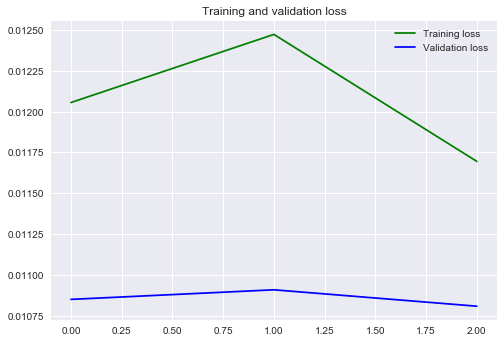

In [613]:
validation_curve(history)

### Evaluate model

In [631]:
def forecast(seed_data, forecast_steps, model):
    '''
    Forecast future returns by making day-by-day predictions.
    
    Args:
        seed_data: Initial input sequence.
        forecast_steps: Defines how many steps into the future to predict.
        model: Trained LSTM prediction model. 
    '''
    
    future = []
    
    for timestep in range(forecast_steps):
        pred = model.predict(seed_data)[0][-1][0]
        future.append(pred)
        seed_data = np.append(seed_data[0][1:], [pred]).reshape(1, seed_data.shape[1], 1)

    return future

In [638]:
# Define initial input sequence for forecasting
seed = company_prices_train.iloc[-window:]

initial_inputs = []
for company in seed:
    initial_inputs.append(seed[company].values.reshape(1, seed.values.shape[0], 1))

In [686]:
# Create forecasts 
forecast_5_day = []
forecast_20_day = []
forecast_100_day = []

for company_seed in initial_inputs:
    forecast_5_day.append(forecast(company_seed, 5, price_only_model))
    forecast_20_day.append(forecast(company_seed, 20, price_only_model))
    forecast_100_day.append(forecast(company_seed, 100, price_only_model))

In [687]:
# Evaluate forecasts
from sklearn.metrics import mean_absolute_error

forecast_5_day_mae = []
for i, pred in enumerate(forecast_5_day):
    forecast_5_day_mae.append(mean_absolute_error(company_prices_test.iloc[0:5, i], pred))
    
forecast_20_day_mae = []
for i, pred in enumerate(forecast_20_day):
    forecast_20_day_mae.append(mean_absolute_error(company_prices_test.iloc[0:20, i], pred))
    
forecast_100_day_mae = []
for i, pred in enumerate(forecast_100_day):
    forecast_100_day_mae.append(mean_absolute_error(company_prices_test.iloc[0:100, i], pred))


print('Average MAE across companies (5 day): {:.6f}'.format(np.mean(forecast_5_day_mae)))
print('Average MAE across companies (20 day): {:.6f}'.format(np.mean(forecast_20_day_mae)))
print('Average MAE across companies (100 day): {:.6f}'.format(np.mean(forecast_100_day_mae)))

Average MAE across companies (5 day): 0.012039
Average MAE across companies (20 day): 0.012486
Average MAE across companies (100 day): 0.011844


### Visualize forecast

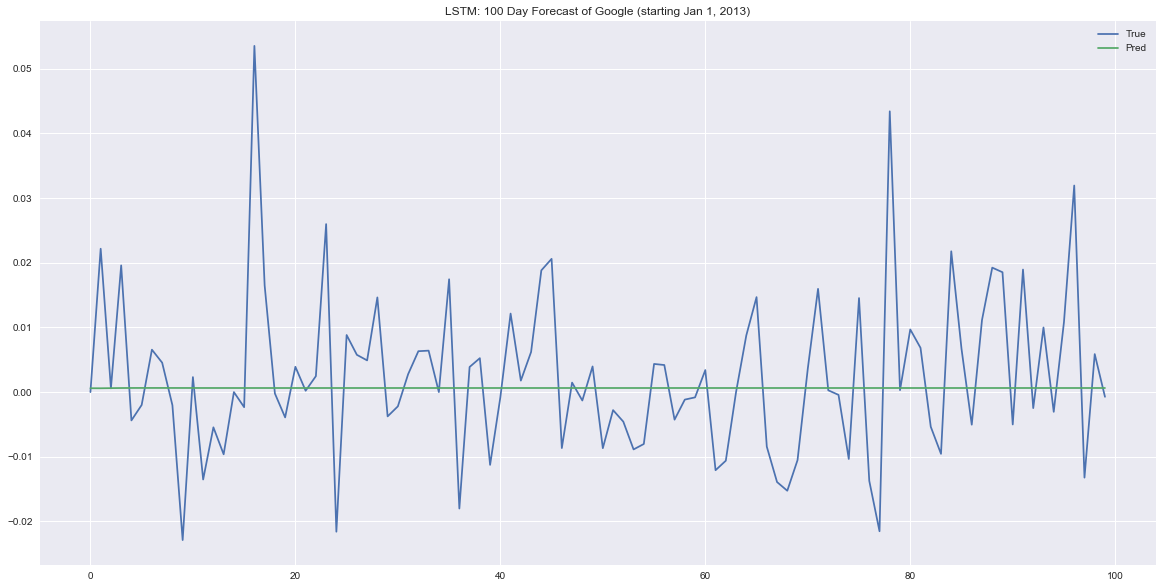

In [689]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(company_prices_test.iloc[0:100, 0].values, label='True')
ax.plot(forecast_100_day[0], label='Pred')
ax.set_title('LSTM: 100 Day Forecast of Google (starting Jan 1, 2013)')
plt.legend()

### Test generator evaluation

In [669]:
mae = price_only_model.evaluate_generator(test_gen, steps=test_steps)
print('Mean absolute error on test data: {:.6f}'.format(mae))

Mean absolute error on test data: 0.009176


<a id='step7'></a>
## ConvNet Feature Extraction

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* **[Step 7](#step7): ConvNet feature extraction**
* [Step 8](#step8): LSTM price+text model

In this section, we'll prepare data for the ConvNet model, develop a model capable of predicting price movements from text information, and extract features from the last layer of the network for input in the recurrent network. 

1. Generate samples of text data (in 2D array form) as input paired with the sum of the next five days of stock returns as output. 

2. Define the ConvNet model architecture for learning the features. 

3. Extract features from last layer of network.

[Back to top](#step0)

In [487]:
companies = ['GOOG', 'AMZN', 'MMM', 'CMG', 'DUK']

company_transcripts_train = [load_company_transcripts(company)['2009':'2012'] for company in companies]
company_prices_train = load_company_price_history(companies, normalize=True)['2009':'2012']

company_transcripts_test = [load_company_transcripts(company)['2013':'2014'] for company in companies]
company_prices_test = load_company_price_history(companies, normalize=True)['2013':'2014']

company_transcripts_val = [load_company_transcripts(company)['2015':'2016'] for company in companies]
company_prices_val = load_company_price_history(companies, normalize=True)['2015':'2016']

2017-09-20 15:28:39,731 - DEBUG - Reading company transcripts for GOOG
2017-09-20 15:28:39,801 - WARNING - 1 duplicates removed from file
2017-09-20 15:28:39,861 - DEBUG - Reading company transcripts for AMZN
2017-09-20 15:28:39,921 - DEBUG - Reading company transcripts for ADBE
2017-09-20 15:28:39,999 - DEBUG - Reading company transcripts for AAPL
2017-09-20 15:28:40,072 - DEBUG - Reading company prices for GOOG
2017-09-20 15:28:40,080 - DEBUG - Reading company prices for AMZN
2017-09-20 15:28:40,084 - DEBUG - Reading company prices for ADBE
2017-09-20 15:28:40,088 - DEBUG - Reading company prices for AAPL
2017-09-20 15:28:40,145 - INFO - Null values found after cleaning: False
2017-09-20 15:28:40,148 - DEBUG - Reading company transcripts for GOOG
2017-09-20 15:28:40,194 - WARNING - 1 duplicates removed from file
2017-09-20 15:28:40,259 - DEBUG - Reading company transcripts for AMZN
2017-09-20 15:28:40,317 - DEBUG - Reading company transcripts for ADBE
2017-09-20 15:28:40,383 - DEBUG 

In [527]:
def text_generator(price_data, text_data, w2v_reduced, window=5, batch_size=1):
    '''
    Creates samples for ConvNet training which accepts a 2D array representation of text as input and predicts the
    following 5 day log-return. 
    
    Args:
        price_data: A Pandas DataFrame consisting of daily price information, consisting of multiple companies
        across the columns. 
        text_data: A list of Pandas Dataframes, each item in the list is a DataFrame of one company's collection
        of earnings call transcripts. 
        w2v_reduced: A dictionary mapping words to a 2D vector representation, used for converting the text
        into a 2D array representation. 
        
    Returns:
        text: A 2D array representation of an earnings call transcript.
        price_target: The resulting 5 day log-return after the earnings call took place. 
    '''
    companies = len(text_data)
    
    # Start with first transcript
    i = 0
    
    # Start with first company
    j = 0
    
    text_docs, lookup = process_text_for_input(text_data[j]['body'], w2v_reduced, norm='l2')
    
    while True:
        # If end of transcripts reached, go to next company
        if i >= len(lookup):
            i = 0
            if j+1 >= companies:
                j=0
            else:
                j+=1
                
            text_docs, lookup = process_text_for_input(text_data[j]['body'], w2v_reduced, norm='l2')
        
        
        event = lookup.index[i]
        text = text_docs[i].reshape(1, text_docs[i].shape[0], text_docs[i].shape[1], 1)
        price_target = company_prices[event : event + pd.to_timedelta('{} days'.format(window+1))].iloc[:,j].sum()
        
        yield text, np.array(price_target).reshape(1)
        
        i+= 1

In [528]:
window_size = 5
batch_size = 12

train_gen = text_generator(company_prices_train, company_transcripts_train, w2v_reduced, 
                           window=window_size, batch_size=batch_size)
train_steps = sum([len(company) for company in company_transcripts_train])


val_gen = text_generator(company_prices_val, company_transcripts_val, w2v_reduced, 
                         window=window_size, batch_size=batch_size)
val_steps = sum([len(company) for company in company_transcripts_val])


test_gen = text_generator(company_prices_test, company_transcripts_test, w2v_reduced, 
                          window=window_size, batch_size=batch_size) 
test_steps = sum([len(company) for company in company_transcripts_test])

In [529]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout

text_features = 10

text_model = Sequential()
text_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(250, 250, 1)))
text_model.add(Conv2D(32, (3, 3), activation='relu'))
text_model.add(MaxPooling2D((4, 4)))
text_model.add(Conv2D(16, (3, 3), activation='relu'))
text_model.add(GlobalAveragePooling2D())
text_model.add(Dense(100, activation='relu'))
text_model.add(Dropout(0.4))
text_model.add(Dense(text_features, activation='relu'))
text_model.add(Dense(1, activation='linear'))

print(text_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 250, 250, 32)      320       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 248, 248, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
global_average_pooling2d_23  (None, 16)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               1700      
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
__________

In [530]:
from keras.callbacks import ModelCheckpoint 

text_model.compile(loss='mean_absolute_error', optimizer='adam')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.text_feature_extractor.hdf5', 
                               verbose=1, save_best_only=True)

# Train LSTM
history = text_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, callbacks=[checkpointer], 
                                         validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


2017-09-20 15:44:14,414 - INFO - 1 same-day events combined.


67/73 [==========================>...] - ETA: 1s - loss: 0.0634

2017-09-20 15:44:26,136 - INFO - 1 same-day events combined.


73/73 [==============================] - 15s - loss: 0.0625 - val_loss: 0.0616
Epoch 2/20
64/73 [=========================>....] - ETA: 1s - loss: 0.0631

2017-09-20 15:44:40,606 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0620 - val_loss: 0.0614
Epoch 3/20
64/73 [=========================>....] - ETA: 1s - loss: 0.0624

2017-09-20 15:44:55,000 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0612 - val_loss: 0.0619
Epoch 4/20
63/73 [========================>.....] - ETA: 1s - loss: 0.0622

2017-09-20 15:45:09,215 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0606 - val_loss: 0.0635
Epoch 5/20
61/73 [========================>.....] - ETA: 2s - loss: 0.0628

2017-09-20 15:45:23,228 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0602 - val_loss: 0.0639
Epoch 6/20
62/73 [========================>.....] - ETA: 1s - loss: 0.0623

2017-09-20 15:45:37,605 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0599 - val_loss: 0.0639
Epoch 7/20
61/73 [========================>.....] - ETA: 2s - loss: 0.0629

2017-09-20 15:45:51,679 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0598 - val_loss: 0.0638
Epoch 8/20
60/73 [=======================>......] - ETA: 2s - loss: 0.0636

2017-09-20 15:46:04,778 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0595 - val_loss: 0.0638
Epoch 9/20
58/73 [======================>.......] - ETA: 2s - loss: 0.0646

2017-09-20 15:46:18,039 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0605 - val_loss: 0.0638
Epoch 10/20
58/73 [======================>.......] - ETA: 2s - loss: 0.0643

2017-09-20 15:46:32,766 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0596 - val_loss: 0.0638
Epoch 11/20
55/73 [=====================>........] - ETA: 3s - loss: 0.0660

2017-09-20 15:46:46,568 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0604 - val_loss: 0.0639
Epoch 12/20
56/73 [======================>.......] - ETA: 2s - loss: 0.0653

2017-09-20 15:47:00,557 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0600 - val_loss: 0.0639
Epoch 13/20
53/73 [====================>.........] - ETA: 3s - loss: 0.0664- ETA: 3s - loss: 0.06

2017-09-20 15:47:13,934 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0598 - val_loss: 0.0640
Epoch 14/20
52/73 [====================>.........] - ETA: 3s - loss: 0.0672

2017-09-20 15:47:27,172 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0600 - val_loss: 0.0640
Epoch 15/20
52/73 [====================>.........] - ETA: 3s - loss: 0.0670

2017-09-20 15:47:40,352 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0609 - val_loss: 0.0641
Epoch 16/20
50/73 [===================>..........] - ETA: 3s - loss: 0.0669

2017-09-20 15:47:53,699 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0595 - val_loss: 0.0641
Epoch 17/20
49/73 [===================>..........] - ETA: 3s - loss: 0.0683

2017-09-20 15:48:07,251 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0597 - val_loss: 0.0641
Epoch 18/20
47/73 [==================>...........] - ETA: 4s - loss: 0.0700

2017-09-20 15:48:20,908 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0608 - val_loss: 0.0641
Epoch 19/20
46/73 [=================>............] - ETA: 4s - loss: 0.0693

2017-09-20 15:48:34,990 - INFO - 1 same-day events combined.


73/73 [==============================] - 14s - loss: 0.0608 - val_loss: 0.0641
Epoch 20/20
47/73 [==================>...........] - ETA: 4s - loss: 0.0672

2017-09-20 15:48:49,127 - INFO - 1 same-day events combined.


73/73 [==============================] - 13s - loss: 0.0597 - val_loss: 0.0642


In [531]:
# Load weights from previous training
text_model.load_weights('saved_models/weights.best.text_feature_extractor.hdf5')

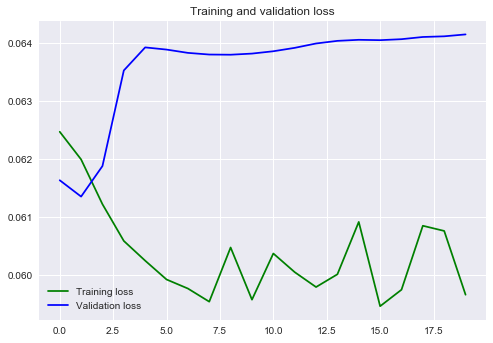

In [532]:
validation_curve(history)

In [403]:
text_model.layers

Using a [method suggested by fchollet](https://github.com/fchollet/keras/issues/41), an indentical network is created with the last layer truncated, exposing the last hidden layer to be used as features that describe the text.

In [533]:
extract_features = Sequential()
extract_features.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                            input_shape=(250, 250, 1), weights=text_model.layers[0].get_weights()))
extract_features.add(Conv2D(32, (3, 3), activation='relu', weights=text_model.layers[1].get_weights()))
extract_features.add(MaxPooling2D((4, 4), weights=text_model.layers[2].get_weights()))
extract_features.add(Conv2D(16, (3, 3), activation='relu', weights=text_model.layers[3].get_weights()))
extract_features.add(GlobalAveragePooling2D(weights=text_model.layers[4].get_weights()))
extract_features.add(Dense(100, activation='relu', weights=text_model.layers[5].get_weights()))
extract_features.add(Dropout(0.4, weights=text_model.layers[6].get_weights()))
extract_features.add(Dense(text_features, activation='linear', weights=text_model.layers[7].get_weights()))

In [536]:
extract_features.predict(text)

array([[-0.0212712 ,  0.00477908, -0.01075181,  0.00255826, -0.01825933,
        -0.00846098,  0.01881904, -0.00580684, -0.01098066, -0.01511178]], dtype=float32)

In [537]:
# Run this cell to inspect a new example
text, price = next(test_gen)

print('Predicted return:\t{}'.format(text_model.predict(text)[0][0]))
print('True return:\t\t{}'.format(price[0]))

Predicted return:	0.01737634837627411
True return:		0.06355231462064292


In [539]:
# Visualize input
from PIL import Image
pillow_image = Image.fromarray(1500*text[0, :, :, 0])
pillow_image.show()

### Evalute model

In [538]:
mae = text_model.evaluate_generator(test_gen, steps=test_steps)
print('Mean absolute error on test data: {}'.format(mae))

Mean absolute error on test data: 0.057885023705180616


<a id='step8'></a>
## LSTM Price+Text Prediction

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* **[Step 8](#step8): LSTM price+text model**

_**Useful resources:**_
* [Understanding LSTM Networks - colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [How Recurrent Neural Networks and Long Short-Term Memory Work - brohrer](http://brohrer.github.io/how_rnns_lstm_work.html)
* [Advanced usage of recurrent neural networks - François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb)
* [Stanford CS231n Lecture 10 | Recurrent Neural Networks](https://www.youtube.com/watch?v=6niqTuYFZLQ&index=10&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv)
* [The Unreasonable Effectiveness of Recurrent Neural Networks - Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Improve Your Python: 'yield' and Generators Explained](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) (for building generators to feed batches of input to the network)

[Back to top](#step0)

In [710]:
companies = ['GOOG', 'AMZN', 'MMM', 'CMG', 'DUK']

company_transcripts_train = [load_company_transcripts(company)['2009':'2012'] for company in companies]
company_prices_train = load_company_price_history(companies, normalize=True)['2009':'2012']

company_transcripts_test = [load_company_transcripts(company)['2013':'2014'] for company in companies]
company_prices_test = load_company_price_history(companies, normalize=True)['2013':'2014']

company_transcripts_val = [load_company_transcripts(company)['2015':'2016'] for company in companies]
company_prices_val = load_company_price_history(companies, normalize=True)['2015':'2016']

2017-09-22 14:25:08,678 - DEBUG - Reading company transcripts for GOOG
2017-09-22 14:25:09,014 - WARNING - 1 duplicates removed from file
2017-09-22 14:25:09,150 - DEBUG - Reading company transcripts for AMZN
2017-09-22 14:25:09,280 - DEBUG - Reading company transcripts for MMM
2017-09-22 14:25:09,437 - DEBUG - Reading company transcripts for CMG
2017-09-22 14:25:09,488 - WARNING - 1 duplicates removed from file
2017-09-22 14:25:09,556 - DEBUG - Reading company transcripts for DUK
2017-09-22 14:25:09,699 - DEBUG - Reading company prices for GOOG
2017-09-22 14:25:09,711 - DEBUG - Reading company prices for AMZN
2017-09-22 14:25:09,716 - DEBUG - Reading company prices for MMM
2017-09-22 14:25:09,720 - DEBUG - Reading company prices for CMG
2017-09-22 14:25:09,725 - DEBUG - Reading company prices for DUK
2017-09-22 14:25:09,801 - INFO - Null values found after cleaning: False
2017-09-22 14:25:09,805 - DEBUG - Reading company transcripts for GOOG
2017-09-22 14:25:09,898 - WARNING - 1 dupli

In [711]:
window_size = 180
batch_size = 128
text_features = 10

train_gen = price_text_generator(company_prices_train, company_transcripts_train, w2v_reduced, extract_features, 
                                 text_features=text_features, window=window_size, batch_size=batch_size)
train_steps = (company_prices_train.shape[0] // batch_size)*company_prices_train.shape[1]


val_gen = price_text_generator(company_prices_val, company_transcripts_val, w2v_reduced, extract_features, 
                               text_features=text_features, window=window_size, batch_size=batch_size)
val_steps = (company_prices_test.shape[0] // batch_size)*company_prices_test.shape[1]


test_gen = price_text_generator(company_prices_test, company_transcripts_test, w2v_reduced, extract_features, 
                                text_features=text_features, window=window_size, batch_size=batch_size) 
test_steps = (company_prices_test.shape[0] // batch_size)*company_prices_test.shape[1]

In [712]:
def price_text_generator(price_data, text_data, w2v_reduced, extract_features_model, text_features, 
                         window=180, batch_size=128):
    ''' Creates samples for training, combining daily price information with extracted text features.
    
    Training/validation/testing data must be split prior to this generator. 
    
    Args:
        price_data: A Pandas DataFrame consisting of daily price information, consisting of multiple companies
        across the columns. 
        text_data: A list of Pandas Dataframes, each item in the list is a DataFrame of one company's collection
        of earnings call transcripts. 
        w2v_reduced: A dictionary mapping words to a 2D vector representation, used for converting the text
        into a 2D array representation.
        extract_features_model: ConvNet model for extracting features from text. 
        text_features: Number of text features extracted from extract_features_model.
        window: Length to build input and output sequences. 
        batch_size: Number of samples to return for batch training. 
        
    Yields:
        input_features: A sequence of prices and daily extracted text features
        [t-window, t-window+1, t-window+2, ..., t-1]
        output_prices: A sequence of prices offset by one day: [t-window+1, t-window+2, t-window+3, ..., t] 
    '''
    
    timesteps = price_data.shape[0]
    companies = price_data.shape[1]
    
    if window + batch_size > timesteps:
        logging.warning('Not enough data to fill a batch, forcing smaller batch size.')
        batch_size = timesteps - window
    
    # Index to keep track of place within price timeseries, corresponds with the last day of output
    i = window
    
    # Index to keep track of company
    j = 0
    
    # Prepare text
    text_docs, lookup = process_text_for_input(text_data[j]['body'], w2v_reduced, norm='l2')
    lookup = lookup.reindex(price_data)
    
    # Create empty array to fill with text features
    text = np.empty((len(lookup), text_features))
    
    # Get text features
    for i, val in enumerate(lookup):
        if np.isnan(val):
            text[i] = np.zeros(text_features)
        else:
            val = int(val)
            text[i] = extract_features_model.predict(text_docs[val].reshape(250, 250, 1))

    while True:
        # If there aren't enough sequential days to fill a batch, start back at top
        if i + batch_size >= timesteps:
            i = window
            
            if j+1 >= companies:
                j=0
            else:
                j+=1
                # Prepare text
                text_docs, lookup = process_text_for_input(text_data[j]['body'], w2v_reduced, norm='l2')
                lookup = lookup.reindex(price_data)

        
        samples = np.arange(i, i + batch_size)
        i += len(samples)
        
        input_prices = np.zeros((batch_size, window, 1))
        input_text = np.zeros((batch_size, window, text_features))
        output_prices = np.zeros((batch_size, window, 1))
        
        for k, sample in enumerate(samples):
            input_prices[k] = price_data.iloc[np.arange(sample-window, sample),j].values.reshape(window, 1)
            input_text[k] = text[sample-window : sample]
            output_prices[k] = price_data.iloc[np.arange(sample-window+1, sample+1),j].values.reshape(window, 1)
        
        input_prices_with_text = np.append(input_prices, input_text, axis=2)
        
        yield input_prices_with_text, output_prices

In [713]:
input_features, output_prices = next(train_gen)

2017-09-22 14:25:23,171 - INFO - 1 same-day events combined.


In [714]:
print('Input features: {}'.format(input_features.shape))
print('Output prices: {}'.format(output_prices.shape))

Input features: (128, 180, 11)
Output prices: (128, 180, 1)


### Build the model

Originally, I had tied the ConvNet feature extraction to the LSTM. However, in an attempt to learn more efficiently, and given the fact that most days do not contain text data, I've untied the ConvNet feature extraction from the recurrent network. 

In [715]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM

# create LSTM
price_text_model = Sequential()
price_text_model.add(LSTM(20, input_shape=(window_size, text_features+1), return_sequences=True))
price_text_model.add(LSTM(60, return_sequences=True))
price_text_model.add(TimeDistributed(Dense(1)))
print(price_text_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 180, 20)           2560      
_________________________________________________________________
lstm_16 (LSTM)               (None, 180, 60)           19440     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 180, 1)            61        
Total params: 22,061.0
Trainable params: 22,061
Non-trainable params: 0.0
_________________________________________________________________
None


In [716]:
from keras.callbacks import ModelCheckpoint 

price_text_model.compile(loss='mean_absolute_error', optimizer='adam')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.price_with_text_features.hdf5', 
                               verbose=1, save_best_only=True)

# Train LSTM
history = price_text_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=3, callbacks=[checkpointer], 
                                         validation_data=val_gen, validation_steps=val_steps)

Epoch 1/3
 7/40 [====>.........................] - ETA: 65s - loss: 0.0153

2017-09-22 14:25:55,255 - INFO - 5 same-day events combined.


37/40 [==========================>...] - ETA: 4s - loss: 0.0130

2017-09-22 14:26:34,527 - INFO - 5 same-day events combined.


39/40 [============================>.] - ETA: 1s - loss: 0.0128

2017-09-22 14:26:39,040 - INFO - 1 same-day events combined.
2017-09-22 14:26:42,893 - INFO - 1 same-day events combined.


Epoch 00000: val_loss improved from inf to 0.01124, saving model to saved_models/weights.best.price_with_text_features.hdf5
40/40 [==============================] - 65s - loss: 0.0128 - val_loss: 0.0112
Epoch 2/3
27/40 [===================>..........] - ETA: 17s - loss: 0.0125

2017-09-22 14:27:23,235 - INFO - 5 same-day events combined.


39/40 [============================>.] - ETA: 1s - loss: 0.0125

2017-09-22 14:27:40,761 - INFO - 1 same-day events combined.
2017-09-22 14:27:44,398 - INFO - 1 same-day events combined.
2017-09-22 14:27:47,642 - INFO - 1 same-day events combined.


Epoch 00001: val_loss did not improve
40/40 [==============================] - 61s - loss: 0.0123 - val_loss: 0.0113
Epoch 3/3
17/40 [===========>..................] - ETA: 31s - loss: 0.0124

2017-09-22 14:28:11,973 - INFO - 5 same-day events combined.


39/40 [============================>.] - ETA: 1s - loss: 0.0118

2017-09-22 14:28:44,660 - INFO - 1 same-day events combined.
2017-09-22 14:28:48,027 - INFO - 1 same-day events combined.


Epoch 00002: val_loss did not improve
40/40 [==============================] - 61s - loss: 0.0119 - val_loss: 0.0114


In [717]:
# Load weights from previous training
price_text_model.load_weights('saved_models/weights.best.price_with_text_features.hdf5')

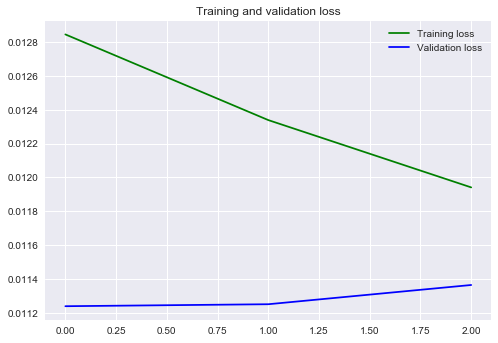

In [718]:
validation_curve(history)

### Evaluate model

In [719]:
mae = price_text_model.evaluate_generator(test_gen, steps=test_steps)
print('Mean absolute error on test data: {:.6f}'.format(mae))

2017-09-22 14:29:52,468 - INFO - 1 same-day events combined.
2017-09-22 14:29:55,605 - INFO - 1 same-day events combined.


Mean absolute error on test data: 0.008930


## Conclusion

* [Step 1](#step1): Download the data
* [Step 2](#step2): Load the data
* [Step 3](#step3): Exploratory data analysis
* [Step 4](#step4): Convert text to word embeddings
* [Step 5](#step5): Benchmark ARIMA model 
* [Step 6](#step6): Benchmark LSTM price model
* [Step 7](#step7): ConvNet feature extraction
* [Step 8](#step8): LSTM price+text model


[Back to top](#step0)